# Step 1:- Import Libraries, Read File, Understand Data 
(Continuously incorporate new libraries as needed to address specific requirements.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import warnings
from scipy.stats import stats, shapiro, anderson
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from yellowbrick.regressor import ResidualsPlot

warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:.2f}'.format
random_seed=42

In [2]:
kaggle_house_price_df=pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
kaggle_house_price_df.shape

(1460, 81)

# Step 2:- EDA

<h3><span style="color:Green;">Common Executables</span></h3>

In [3]:
def numerical_feature_list(df):
    return list(set(kaggle_house_price_df.select_dtypes(exclude='object').columns.tolist())-{'Id','SalePrice'})

In [4]:
def categorical_feature_list(df):
    return [col for col in df.columns if df[col].dtype == 'object']

In [5]:
def drop_columns(df,cols):
    df.drop(cols, axis=1, inplace=True)

<b><span style="color:blue;">Handling Missing Values:</span></b> According to the ‘data_description.txt’ file, many columns are expected to have null values. Instead of directly replacing all missing values with median/mean/mode, we adopt the following strategy. First, we check the count of missing values for each column. If the count is high, we replace the missing values with 0/0.00/‘N/A’; otherwise, we opt for mean/mode imputation.

In [6]:
def handle_missing_data(df):
    threshold_value= 10
    
    for col in categorical_feature_list(df):
        missing_count = df[col].isnull().sum()
        if missing_count > threshold_value:
            df[col].fillna('N/A', inplace=True)
        else:
            mode_val = df[col].mode().iloc[0]
            df[col].fillna(mode_val, inplace=True)

    for col in numerical_feature_list(df):
        missing_row_count = df[col].isnull().sum()
        if missing_count > threshold_value:
            df[col].fillna(0, inplace=True)
        else:
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)

In [7]:
def preprocessing_remainder(df):
    df.drop_duplicates(inplace=True)

In [8]:
def print_prediction(y_test, y_pred):
    #results_actual = pd.Series(test_y,name='Actual')
    results_predicted = pd.DataFrame(y_pred,columns=['Predicted'])
    results = pd.concat([y_test.reset_index(drop=True), results_predicted.reset_index(drop=True)], axis=1)
    results.columns=['Actual','Predicted']
    return results

In [9]:
def residual_check(y_test, y_pred):
    rmse_val=np.sqrt(mean_squared_error(y_test, y_pred))
    r2_val=r2_score(y_test, y_pred)
    print("rmse= ",rmse_val," and r2_score= ",r2_val)
    return rmse_val,r2_val

In [10]:
kaggle_house_price_df.iloc[:5,:20]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL        65.00     8450   Pave   NaN      Reg   
1   2          20       RL        80.00     9600   Pave   NaN      Reg   
2   3          60       RL        68.00    11250   Pave   NaN      IR1   
3   4          70       RL        60.00     9550   Pave   NaN      IR1   
4   5          60       RL        84.00    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  
0       Norm     1Fam     2Story            7            5       2003  
1       Norm     1Fam     1Story            6            8       1976  
2       Norm     1Fam     2Story            7            5       2001  
3       Norm     1Fam     2Story            7            5       1915  
4       Norm     1Fam     2Story            8            5       2000

In [11]:
kaggle_house_price_df.info()
kaggle_house_price_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Id  MSSubClass MSZoning  LotFrontage   LotArea Street Alley  \
count  1460.00     1460.00     1460      1201.00   1460.00   1460    91   
unique     NaN         NaN        5          NaN       NaN      2     2   
top        NaN         NaN       RL          NaN       NaN   Pave  Grvl   
freq       NaN         NaN     1151          NaN       NaN   1454    50   
mean    730.50       56.90      NaN        70.05  10516.83    NaN   NaN   
std     421.61       42.30      NaN        24.28   9981.26    NaN   NaN   
min       1.00       20.00      NaN        21.00   1300.00    NaN   NaN   
25%     365.75       20.00      NaN        59.00   7553.50    NaN   NaN   
50%     730.50       50.00      NaN        69.00   9478.50    NaN   NaN   
75%    1095.25       70.00      NaN        80.00  11601.50    NaN   NaN   
max    1460.00      190.00      NaN       313.00 215245.00    NaN   NaN   

       LotShape LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature  \
count      1460        1460      1460  ...  1460.00      7    281          54   
unique        4           4         2  ...      NaN      3      4           4   
top         Reg         Lvl    AllPub  ...      NaN     Gd  MnPrv        Shed   
freq        925        1311      1459  ...      NaN      3    157          49   
mean        NaN         NaN       NaN  ...     2.76    NaN    NaN         NaN   
std         NaN         NaN       NaN  ...    40.18    NaN    NaN         NaN   
min         NaN         NaN       NaN  ...     0.00    NaN    NaN         NaN   
25%         NaN         NaN       NaN  ...     0.00    NaN    NaN         NaN   
50%         NaN         NaN       NaN  ...     0.00    NaN    NaN         NaN   
75%         NaN         NaN       NaN  ...     0.00    NaN    NaN         NaN   
max         NaN         NaN       NaN  ...   738.00    NaN    NaN         NaN   

        MiscVal  MoSold  YrSold  SaleType  SaleCondition  SalePrice  
count   1460.00 1460.00 1460.00      1460           1460    1460.00  
unique      NaN     NaN     NaN         9              6        NaN  
top         NaN     NaN     NaN        WD         Normal        NaN  
freq        NaN     NaN     NaN      1267           1198        NaN  
mean      43.49    6.32 2007.82       NaN            NaN  180921.20  
std      496.12    2.70    1.33       NaN            NaN   79442.50  
min        0.00    1.00 2006.00       NaN            NaN   34900.00  
25%        0.00    5.00 2007.00       NaN            NaN  129975.00  
50%        0.00    6.00 2008.00       NaN            NaN  163000.00  
75%        0.00    8.00 2009.00       NaN            NaN  214000.00  
max    15500.00   12.00 2010.00       NaN            NaN  755000.00  

[11 rows x 81 columns]

Id column will not contribute in any analysis. So we will drop it

In [12]:
drop_columns(kaggle_house_price_df,'Id')

<h3><span style="color: brown;"> Check Null Entries </span> </h3>

In [13]:
kaggle_house_price_df_count = pd.DataFrame({
    'Column Name': kaggle_house_price_df.columns,
    'Data Type': kaggle_house_price_df.dtypes.values,
    'Null Count': kaggle_house_price_df.isnull().sum().values
})

kaggle_house_price_df_count[kaggle_house_price_df_count['Null Count'] > 0].sort_values(by=['Data Type','Null Count'])

Column Name Data Type  Null Count
25    MasVnrArea   float64           8
58   GarageYrBlt   float64          81
2    LotFrontage   float64         259
41    Electrical    object           1
24    MasVnrType    object           8
29      BsmtQual    object          37
30      BsmtCond    object          37
32  BsmtFinType1    object          37
31  BsmtExposure    object          38
34  BsmtFinType2    object          38
57    GarageType    object          81
59  GarageFinish    object          81
62    GarageQual    object          81
63    GarageCond    object          81
56   FireplaceQu    object         690
72         Fence    object        1179
5          Alley    object        1369
73   MiscFeature    object        1406
71        PoolQC    object        1453

<h3><span style="color: brown;"> Handle Missing Values </span> </h3>

In data_description.txt file we can see for almost all columns can have null value.
1. If the number of missing value<threshold then we will replace it with mean/mode value. Else
2. For float type we will replace with null values with 0.00
3. For object type columns (except Electrical) we will replace the null values with 'N/A'
4. For float type we will replace with null values with 0

In [14]:
handle_missing_data(kaggle_house_price_df)

<h3><span style="color: brown;"> Handle Duplicate Data </span> </h3>

In [15]:
preprocessing_remainder(kaggle_house_price_df)

<h3><span style="color: brown;">Visualization</span></h3>

<h4><span style="color: pink;">Lets try to understand how our dependent variable data is distributed</span></h4>

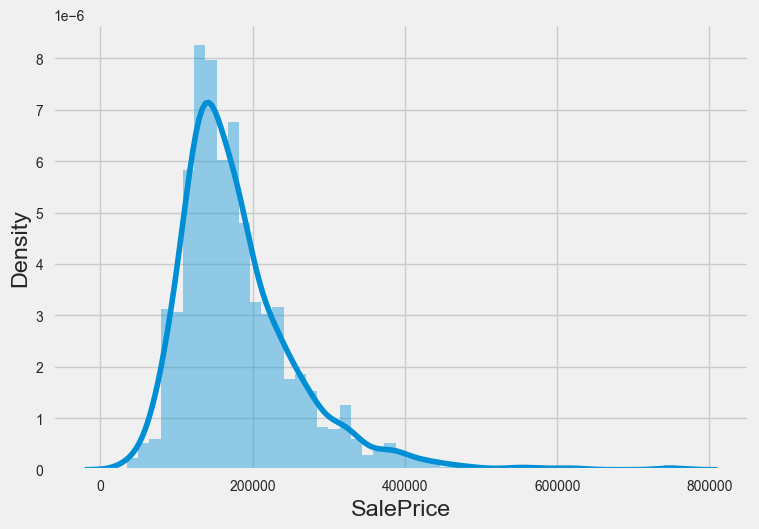

In [16]:
sns.distplot(kaggle_house_price_df['SalePrice'])
plt.show()

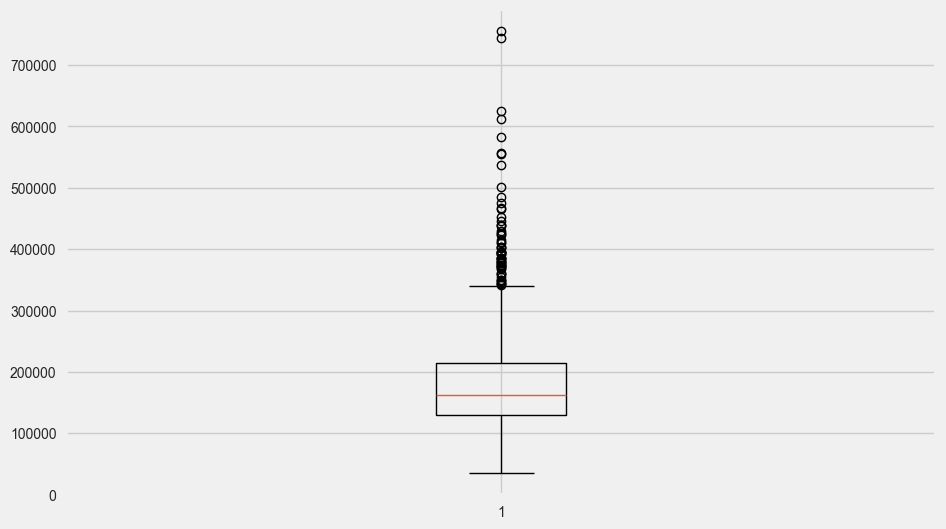

In [17]:
plt.figure(figsize=(10,6))
plt.boxplot(kaggle_house_price_df['SalePrice'])
plt.show()

<h4><span style="color:pink;">Visualize Distribution for Numerical features</span></h4>

<h4><span style="color: brown;">Relationship between Dependent and Independent Variables</span></h4>

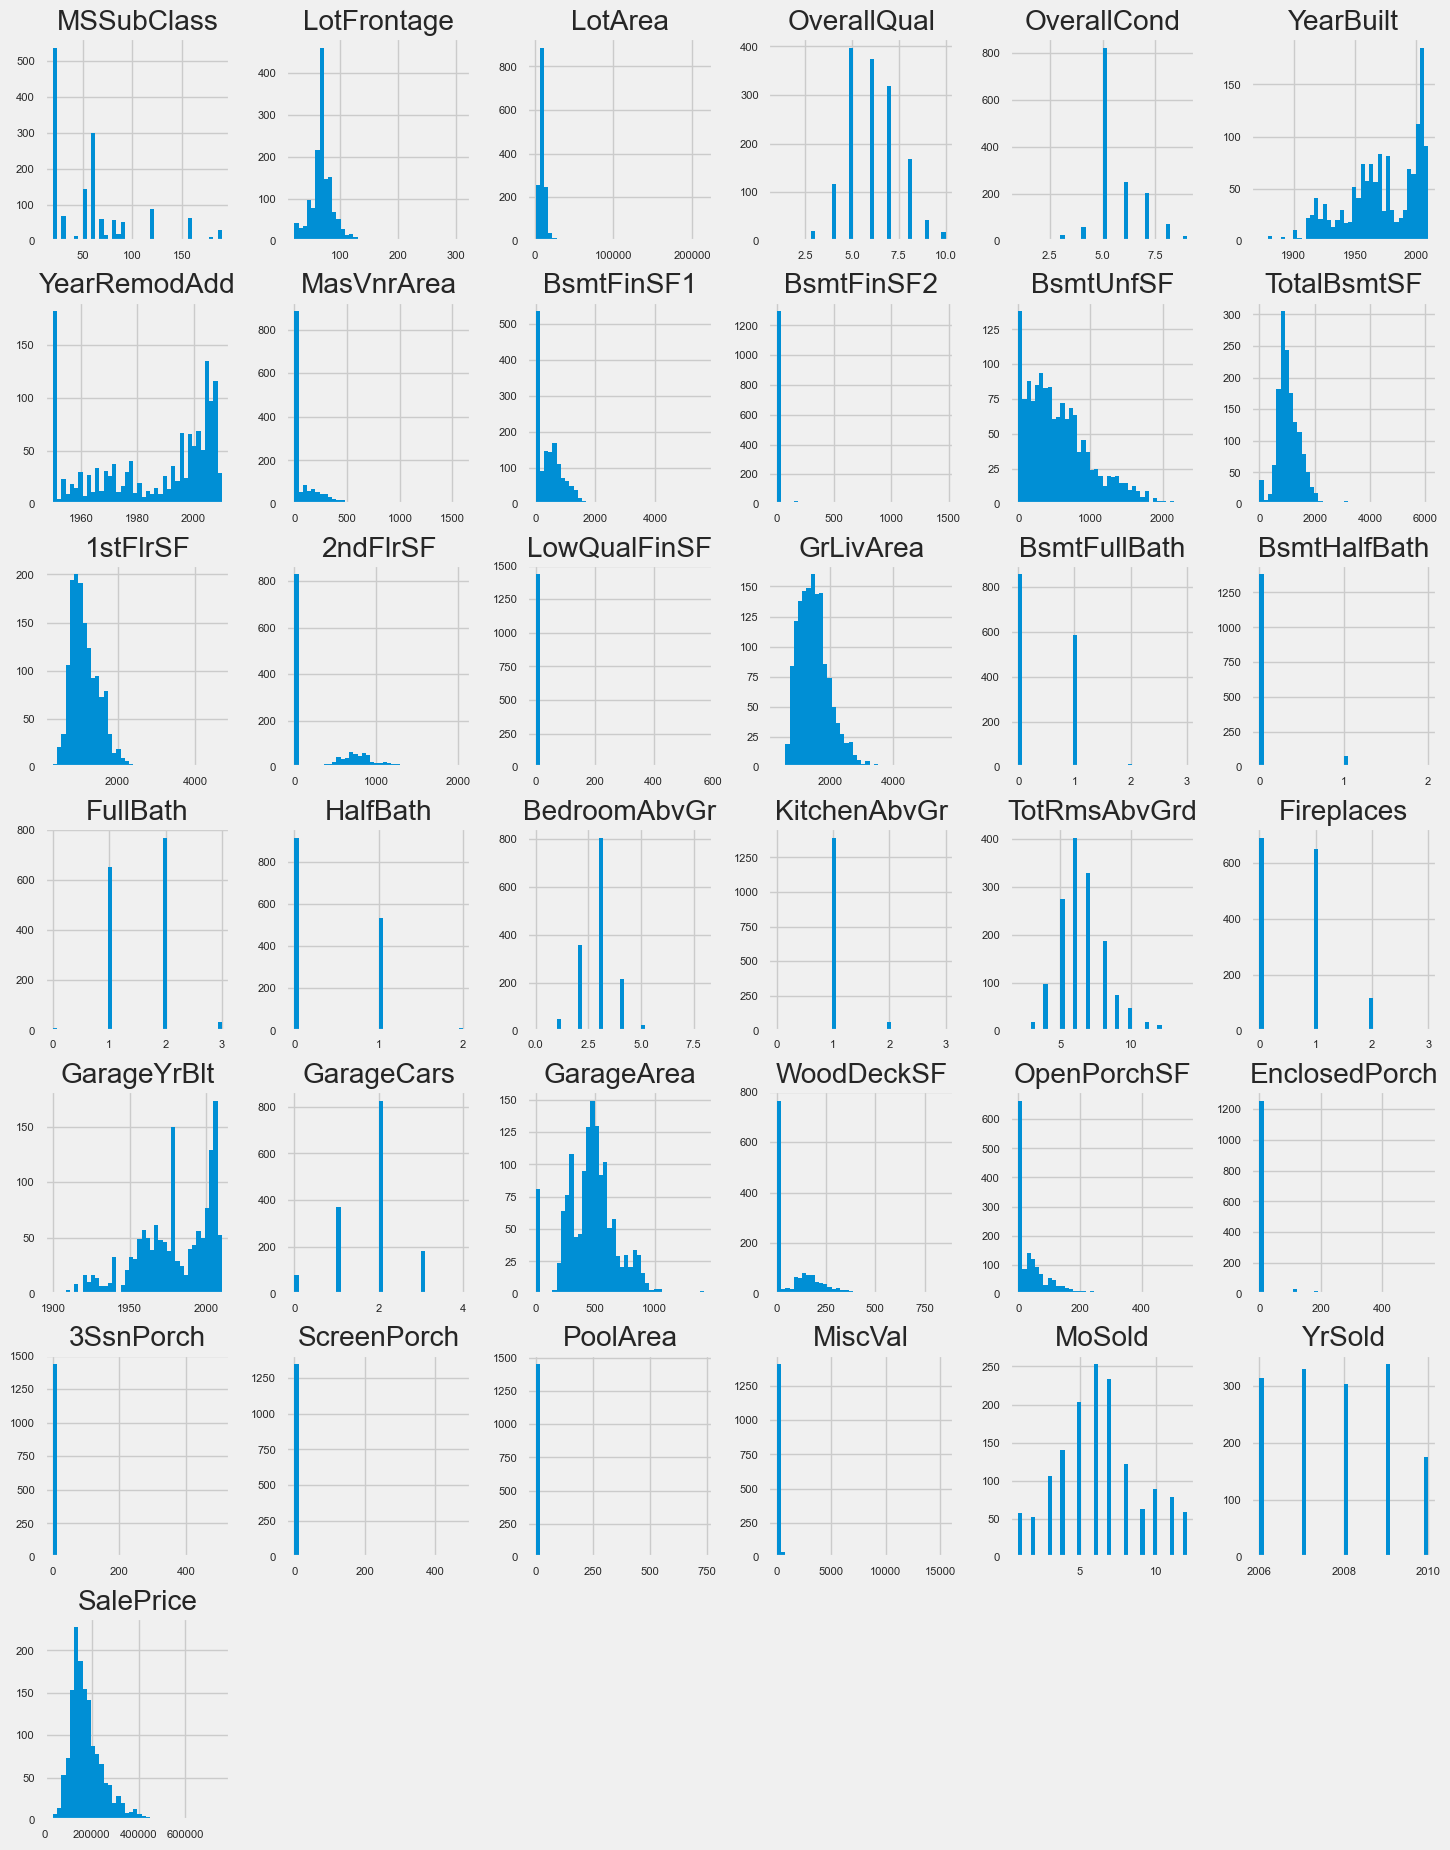

In [18]:
kaggle_house_price_df.hist(figsize=(16,22),bins=40,xlabelsize=8, ylabelsize=8);

From histogram we can see below features will not add much to the analysis-> BasmtFinSF2,2ndFlrSF,LowQualFinSF,BsmtHalfBath,KitchenAbvGr,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal. But before dropping them lets check the correlation value and relationship strength by visualizing pair plot.

<h4><span style="color:brown;">Check correlation</span></h4>

Start with pair plots. A pair plot can assist in identifying potential features that have a strong linear relationship with the target variable (SalePrice). It also provides an initial overview of the data distribution and potential outliers. 

In [19]:
numerical_columns=numerical_feature_list(kaggle_house_price_df)

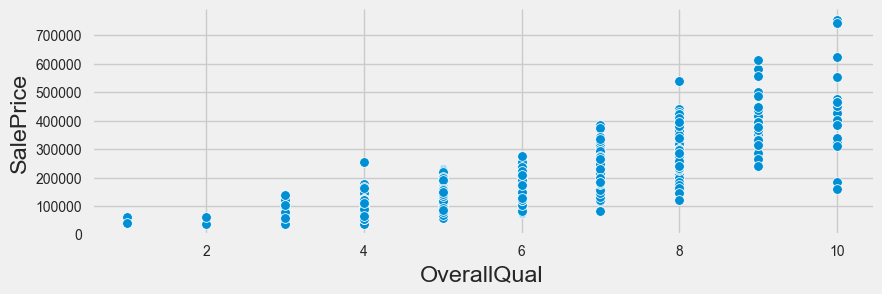

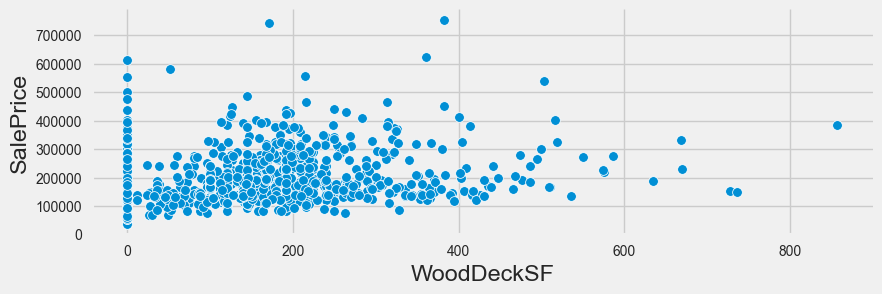

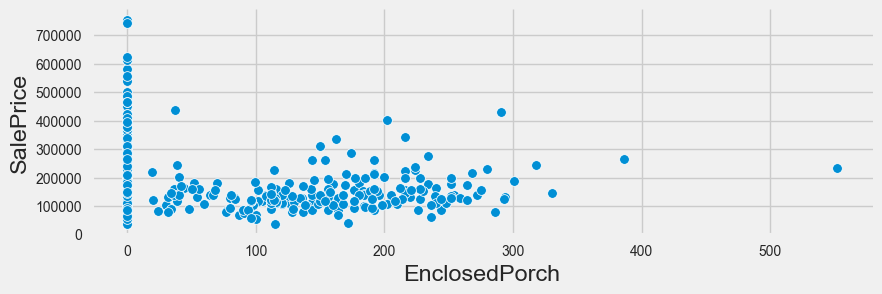

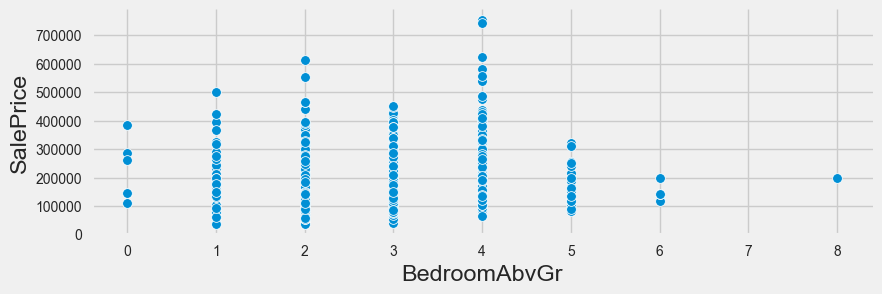

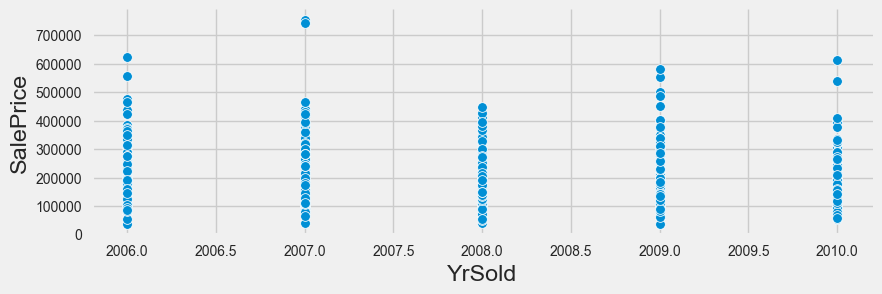

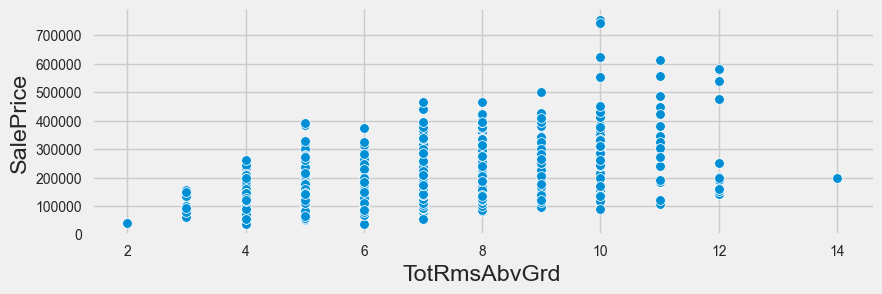

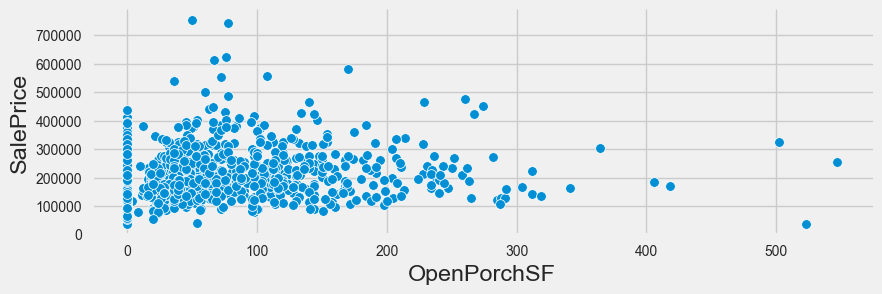

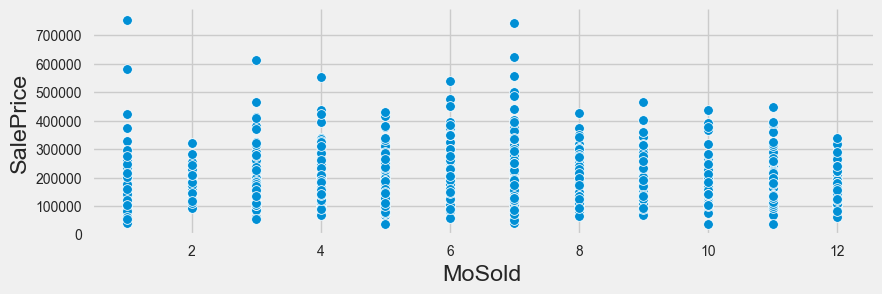

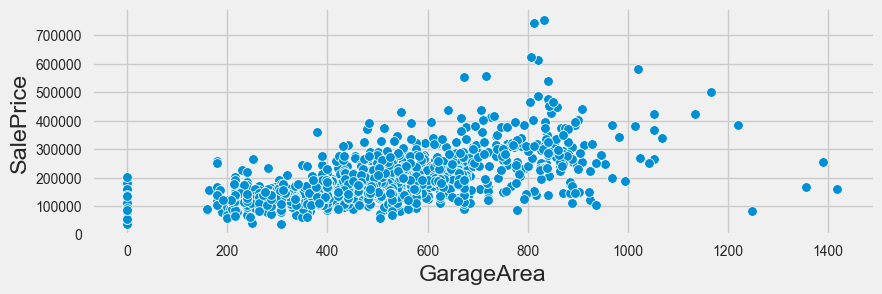

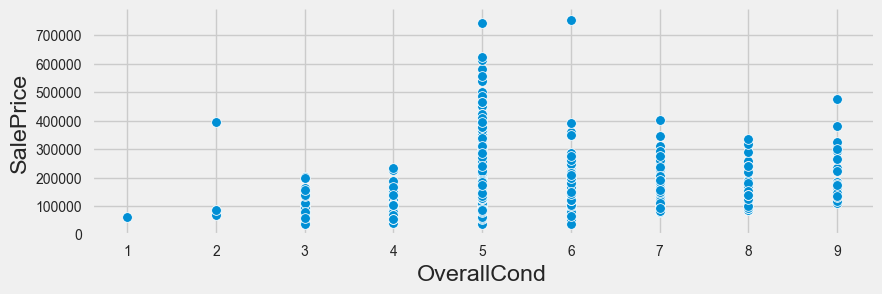

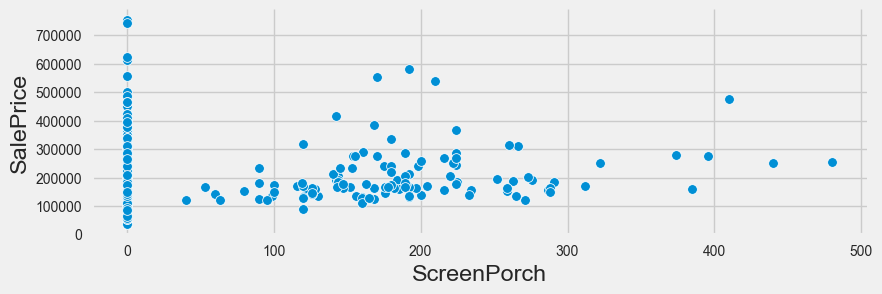

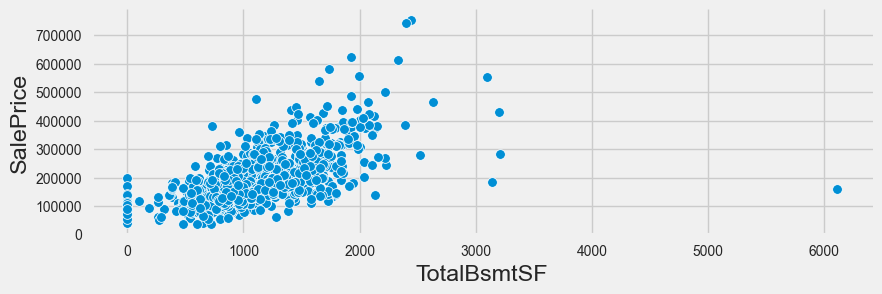

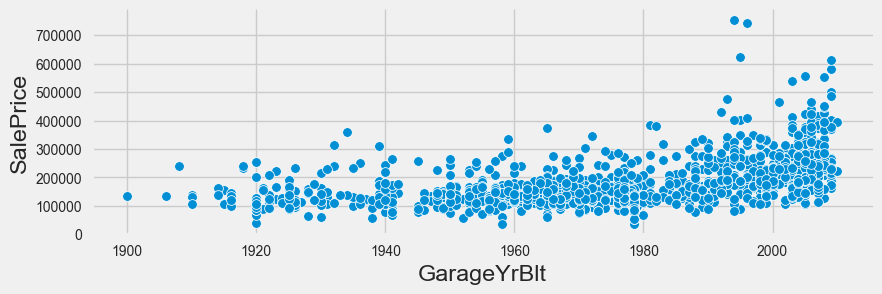

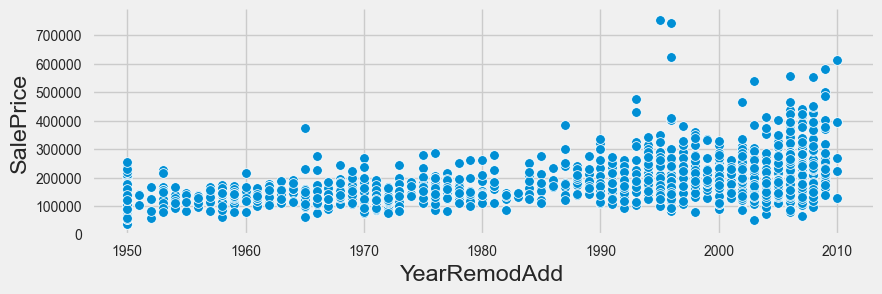

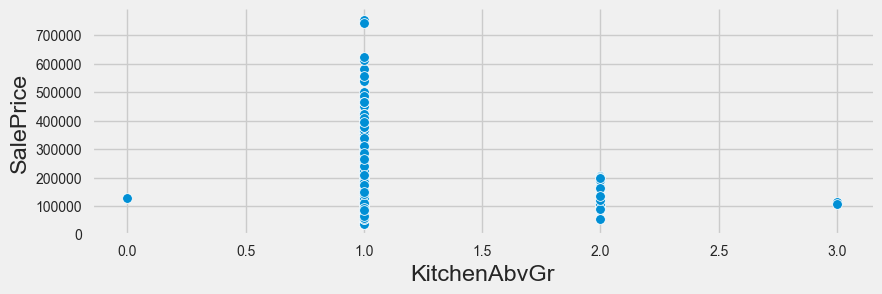

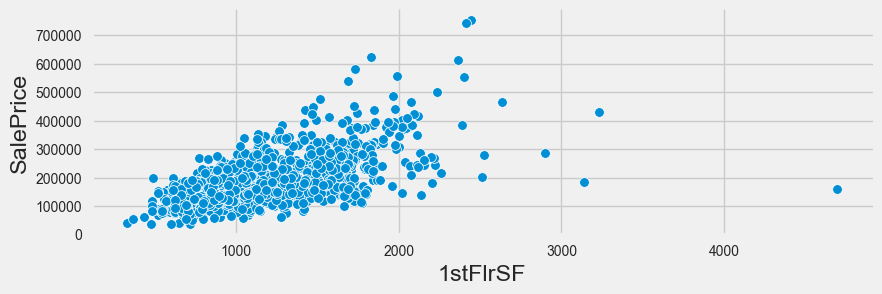

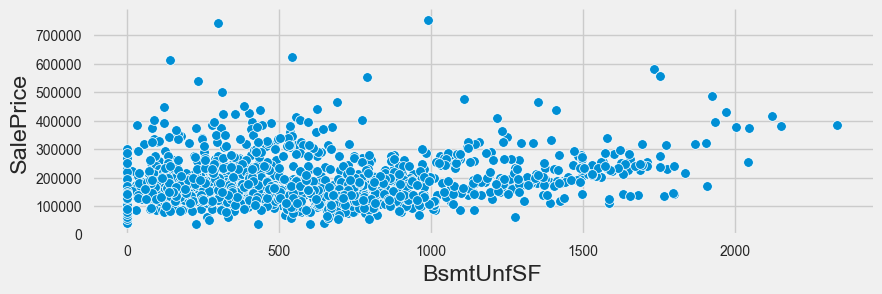

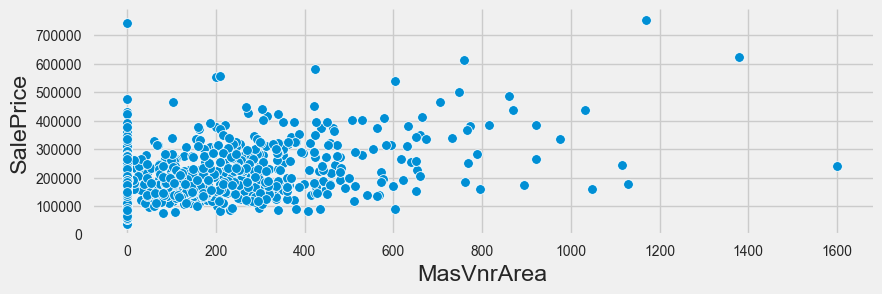

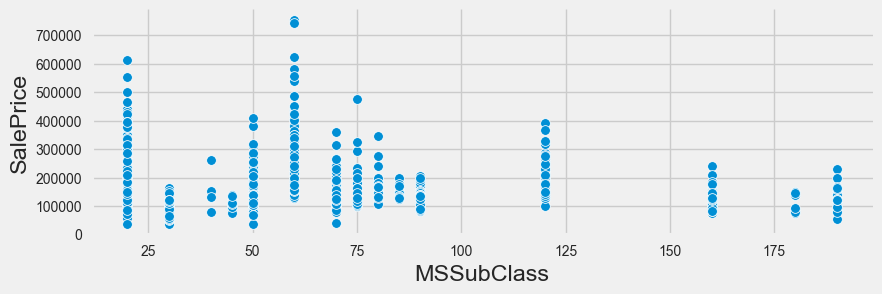

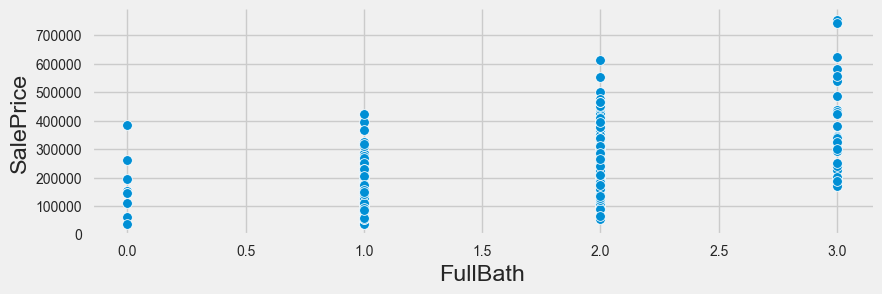

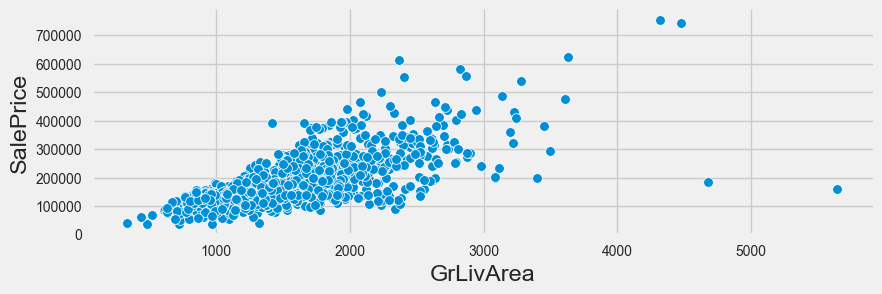

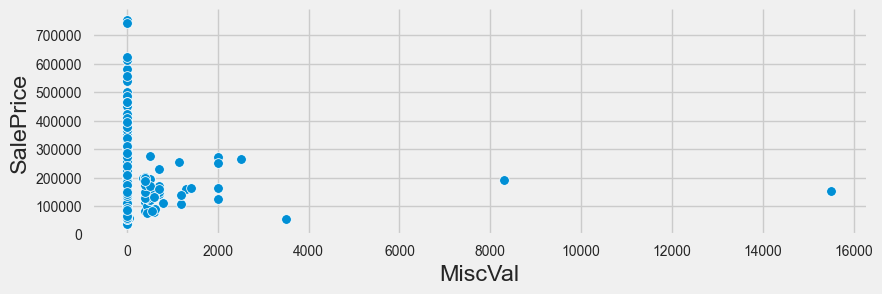

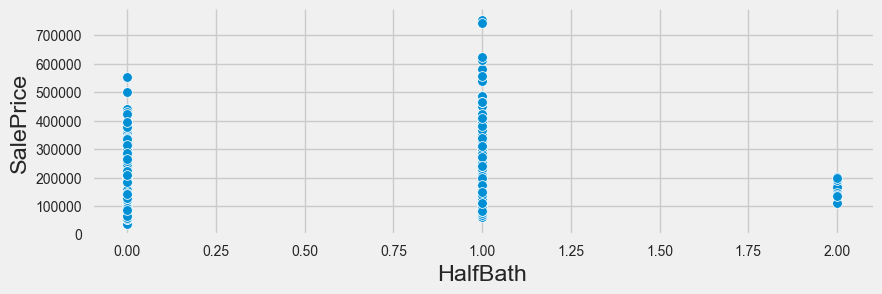

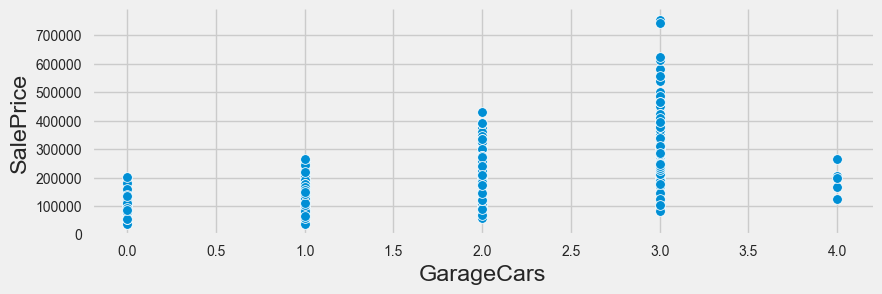

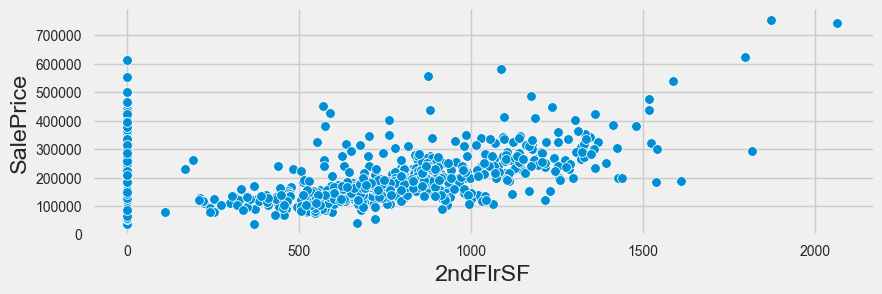

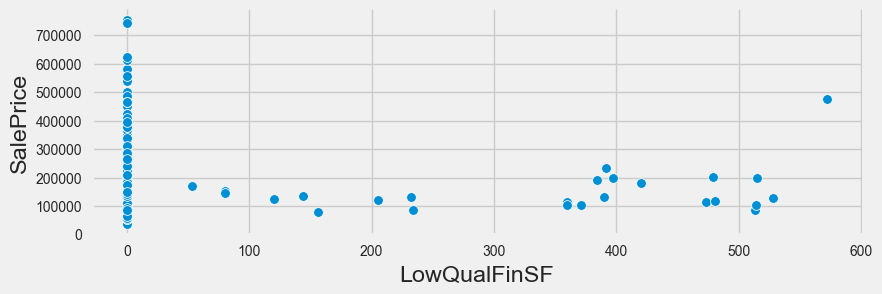

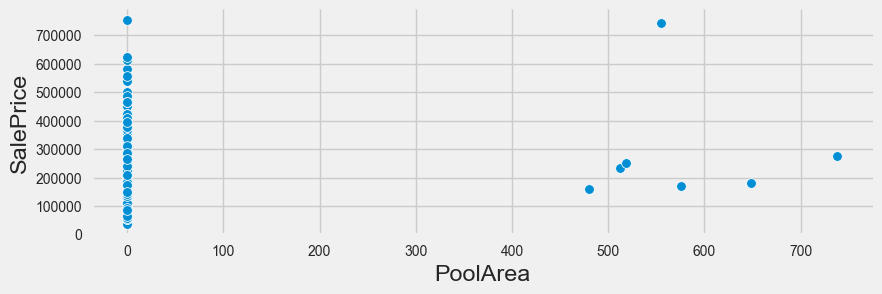

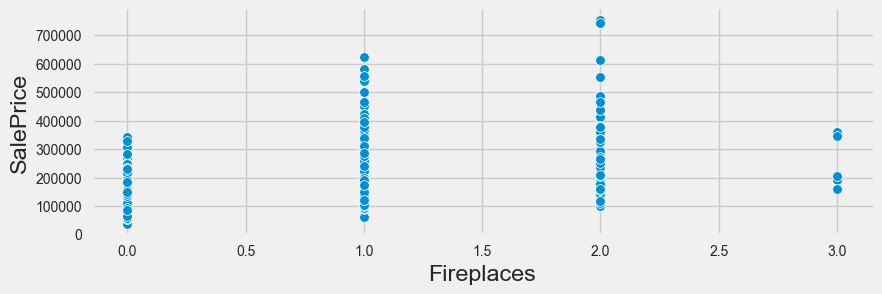

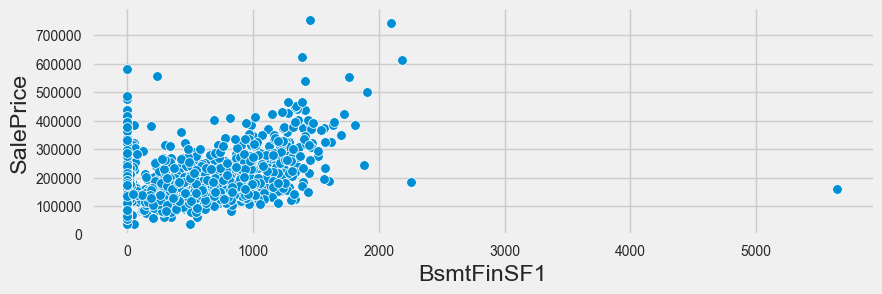

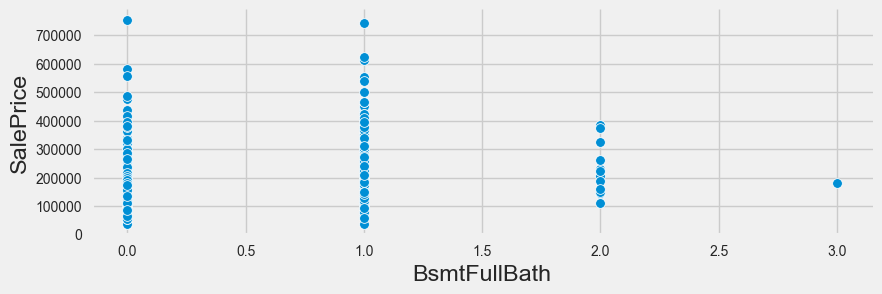

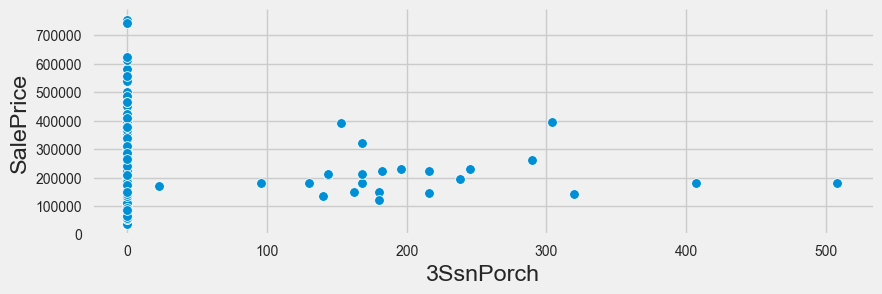

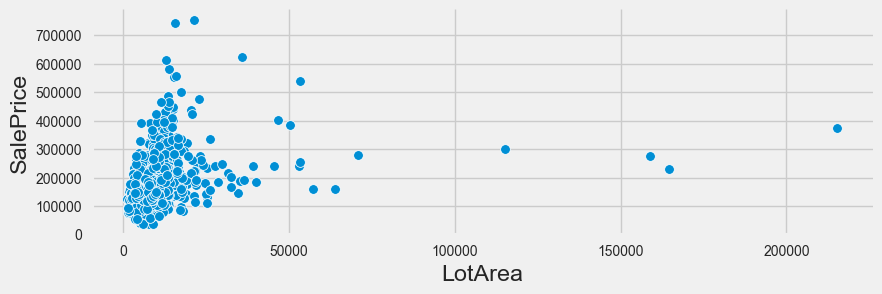

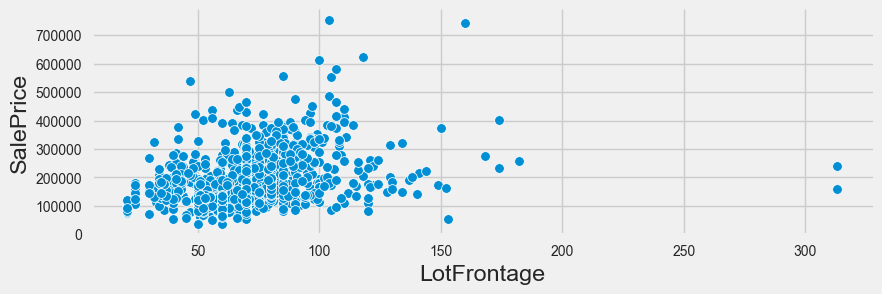

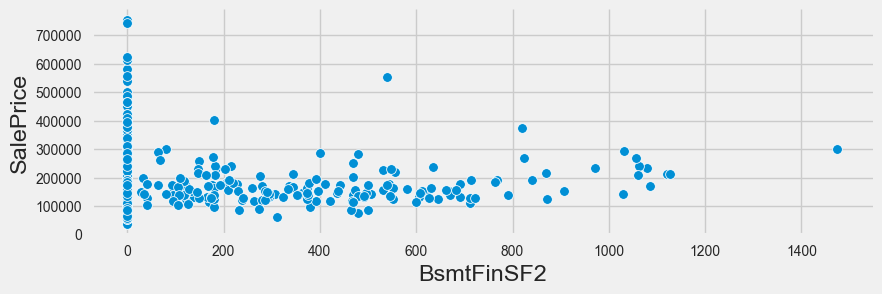

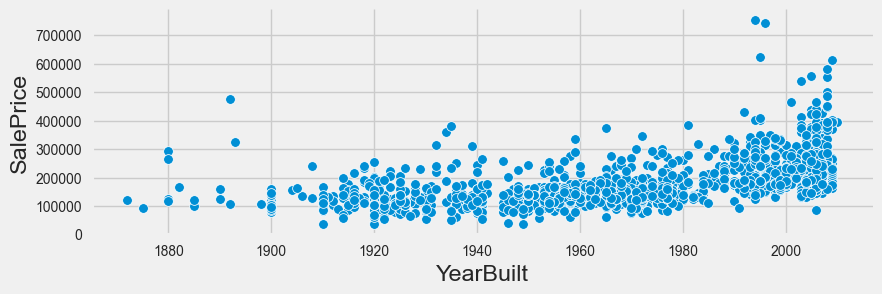

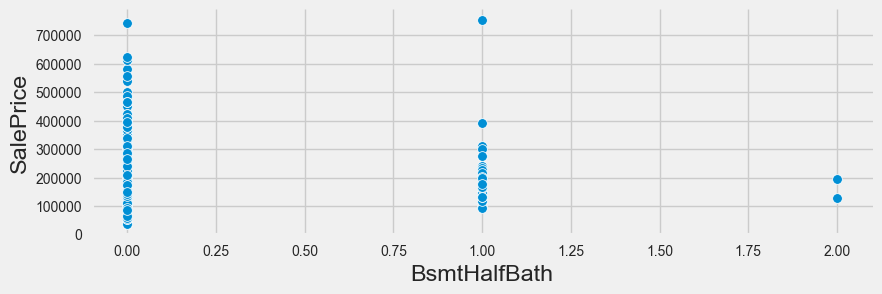

In [20]:
data_to_plot = pd.concat([kaggle_house_price_df['SalePrice'], kaggle_house_price_df[numerical_columns]], axis=1)
for col in numerical_columns :
 sns.pairplot(data_to_plot,y_vars=['SalePrice'],x_vars=[col],height=3, aspect=3)
plt.show()

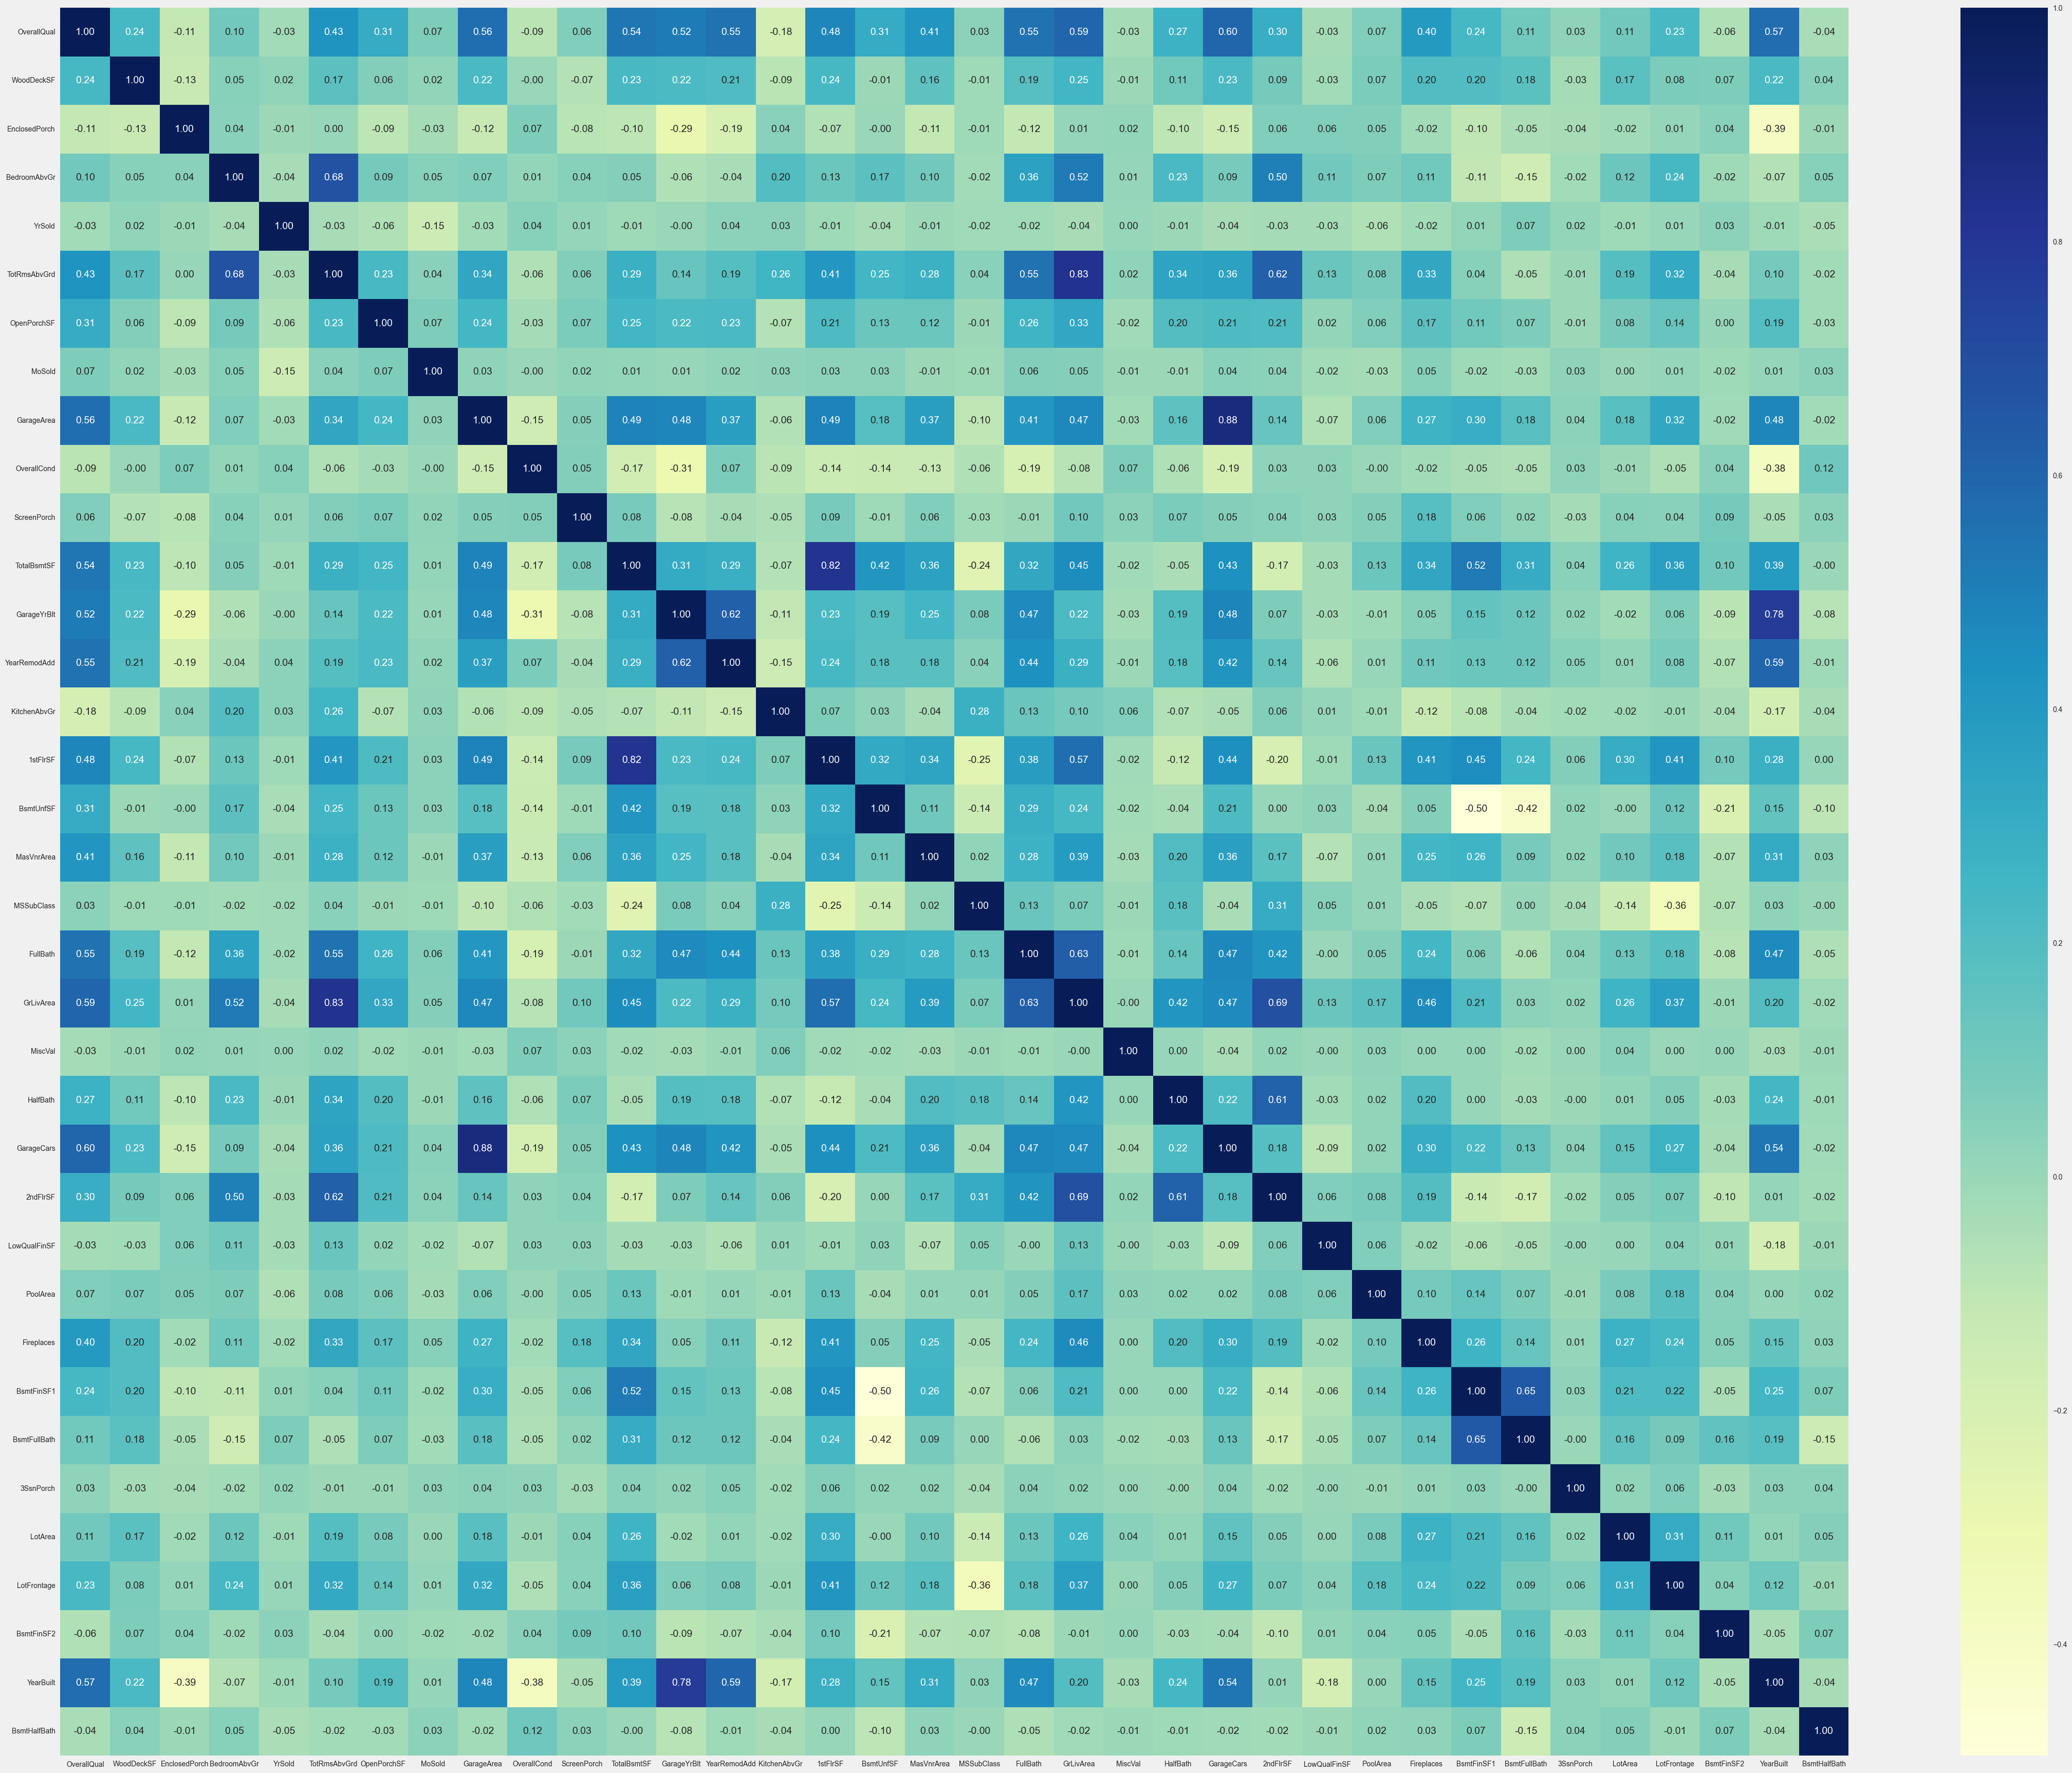

In [21]:
numerical_columns_df=kaggle_house_price_df[numerical_columns]
plt.figure(figsize=(50,42))
sns.heatmap(numerical_columns_df.corr(),cmap='YlGnBu',annot=True,fmt='.2f',xticklabels=True,yticklabels=True)
plt.show()

Lets check significant correlation (to findout golden features)

In [22]:
correlation_threshold=0.2
correlations = kaggle_house_price_df[numerical_columns].apply(lambda x: x.corr
                                                              (kaggle_house_price_df['SalePrice']))
drop_columns(kaggle_house_price_df,correlations[abs(correlations)<correlation_threshold].index)

In [23]:
correlations[abs(correlations)>correlation_threshold]

OverallQual    0.79
WoodDeckSF     0.32
TotRmsAbvGrd   0.53
OpenPorchSF    0.32
GarageArea     0.62
TotalBsmtSF    0.61
GarageYrBlt    0.47
YearRemodAdd   0.51
1stFlrSF       0.61
BsmtUnfSF      0.21
MasVnrArea     0.48
FullBath       0.56
GrLivArea      0.71
HalfBath       0.28
GarageCars     0.64
2ndFlrSF       0.32
Fireplaces     0.47
BsmtFinSF1     0.39
BsmtFullBath   0.23
LotArea        0.26
LotFrontage    0.33
YearBuilt      0.52
dtype: float64

From the histogram, we identified columns such as ‘BsmtFinSF2’, ‘2ndFlrSF’, ‘LowQualFinSF’, ‘BsmtHalfBath’, ‘KitchenAbvGr’, ‘EnclosedPorch’, ‘3SsnPorch’, ‘ScreenPorch’, ‘PoolArea’, and ‘MiscVal’ for deletion. However, most columns were deleted due to correlation, leaving only ‘2ndFlrSF’ with a correlation of 0.32.

Upon analyzing the pair plot, we observed that for this specific feature, when it is absent, the sale price can vary from low to high. However, when this feature is present, a positive correlation between the feature and sale price becomes apparent. Therefore, I suggest retaining this column to gain a better understanding of the data

<h4><span style="color:brown;">Check data distribution (if normally distributed or skewed)</span></h4><br><b>Why are we checking normality of the distribution:-</b> Some machine learning algorithms perform better when features have a more symmetric, normal distribution. It simplifies the analysis and understanding of feature behaviors. Having said that it does not mean we will only choose the features that are normally distributed we will look at all the features how many of them are normally distributed and choose the correct model accordingly.

In [24]:
numerical_columns=numerical_feature_list(kaggle_house_price_df)
categorical_columns=categorical_feature_list(kaggle_house_price_df)

<u>To check the normality we will do Shapiro-Wilk test and Anderson-Darling test.</u><br><h4><span style="color:blue;"> Shapiro-Wilk test:- </span></h4>The null hypothesis of the Shapiro-Wilk test is that the data follows a normal distribution. A low p-value (typically less than 0.05) indicates that you reject the null hypothesis, suggesting that the data is not normally distributed.<br><h4><span style="color:blue;"> Anderson-Darling test:- </span></h4>The statistic is compared to critical values at different significance levels. If the statistic is greater than the critical value, you reject the null hypothesis (non-normal distribution).

In [25]:
for column in numerical_columns:
    stat, p = shapiro(kaggle_house_price_df[column])
    print(f'Shapiro-Wilk Test for {column}: Statistic={stat}, p-value={p}')

    result = anderson(kaggle_house_price_df[column])
    print(f'Anderson-Darling Test for {column}: Statistic={result.statistic}, Critical Values={result.critical_values}')
    print('*****************************************************')

Shapiro-Wilk Test for OverallQual: Statistic=0.948009192943573, p-value=2.6881777040033577e-22
Anderson-Darling Test for OverallQual: Statistic=35.230011585458215, Critical Values=[0.574 0.654 0.785 0.916 1.089]
*****************************************************
Shapiro-Wilk Test for WoodDeckSF: Statistic=0.7685167789459229, p-value=3.2283114021115136e-41
Anderson-Darling Test for WoodDeckSF: Statistic=119.71213740485246, Critical Values=[0.574 0.654 0.785 0.916 1.089]
*****************************************************
Shapiro-Wilk Test for HalfBath: Statistic=0.638007640838623, p-value=0.0
Anderson-Darling Test for HalfBath: Statistic=267.0045184059886, Critical Values=[0.574 0.654 0.785 0.916 1.089]
*****************************************************
Shapiro-Wilk Test for TotRmsAbvGrd: Statistic=0.9422868490219116, p-value=2.0137621514480412e-23
Anderson-Darling Test for TotRmsAbvGrd: Statistic=31.94098041337338, Critical Values=[0.574 0.654 0.785 0.916 1.089]
***************

We can see both the test proved none of the numerical features follows normal distribution. Now lets check this graphically. <p>a <b><span style="color:blue;">QQ plot</span></b> can provide additional insights and help us to understand the nature of the deviation. It might reveal specific patterns or deviations that the statistical tests don’t capture.</p> <b>Note:-</b>Default distribution in QQ plot is normal.

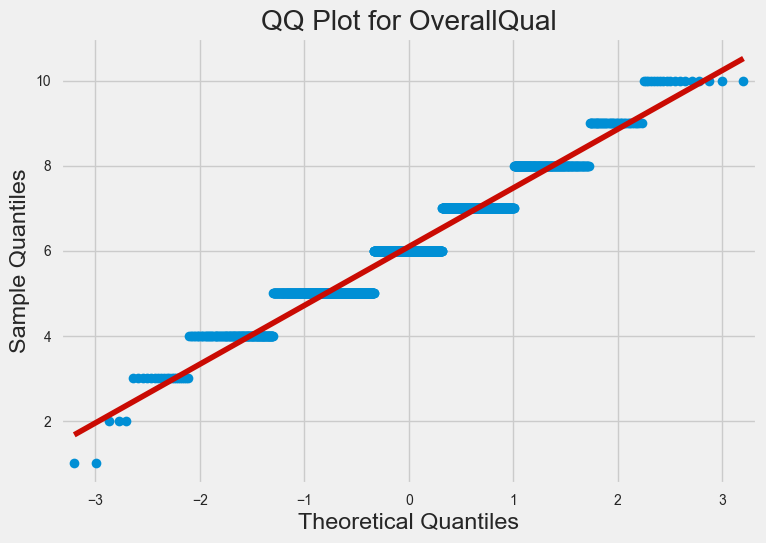

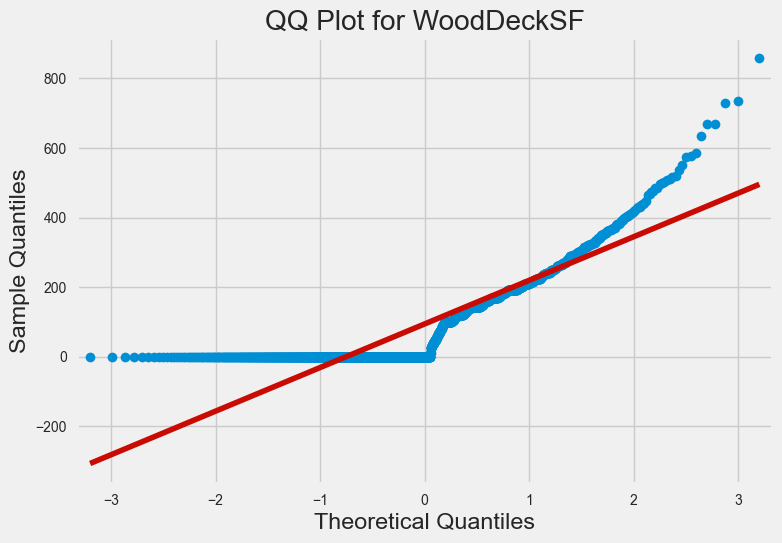

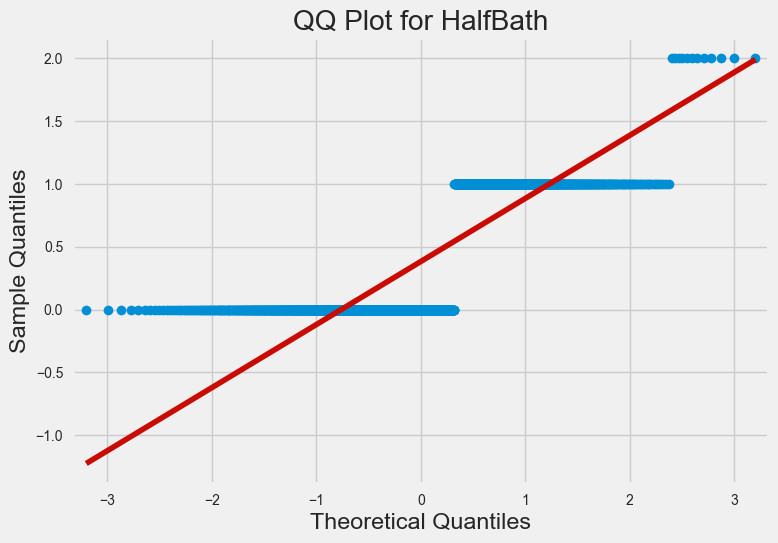

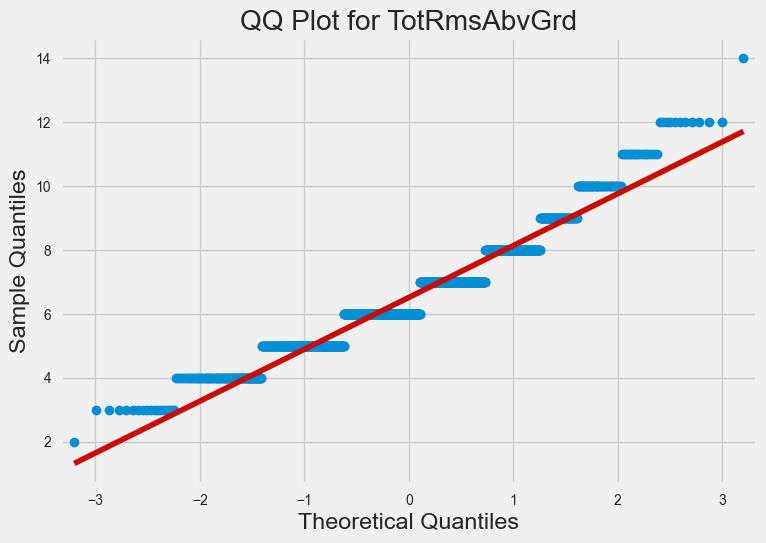

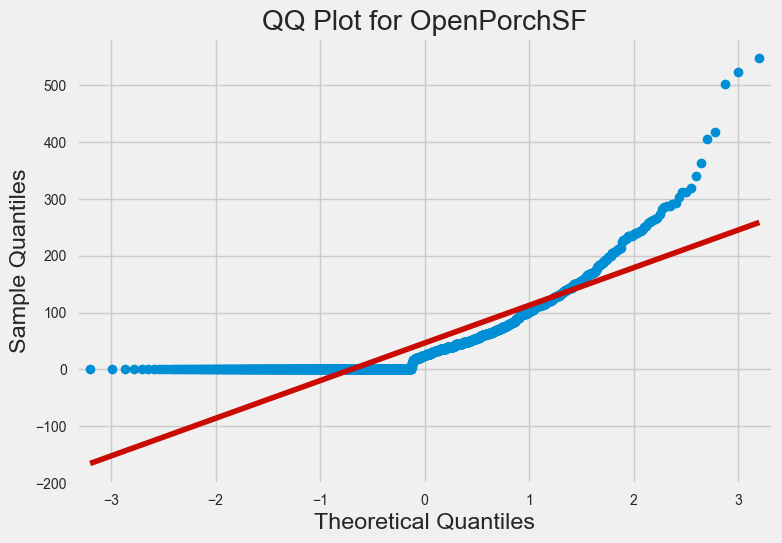

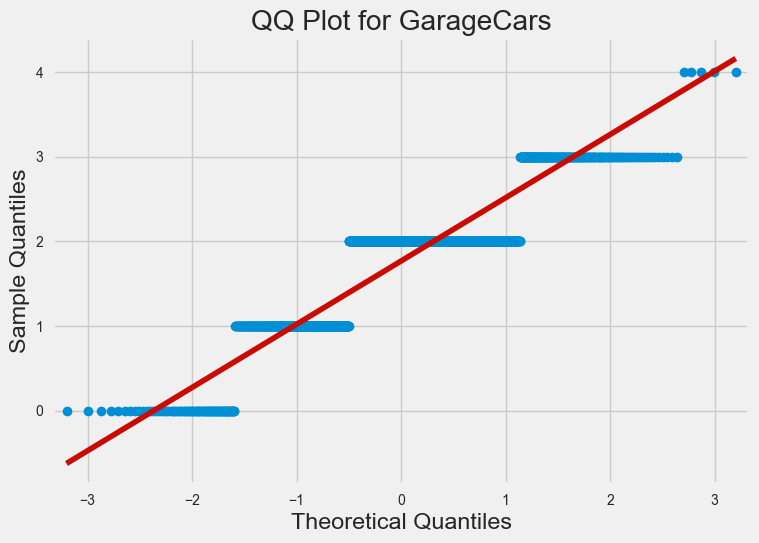

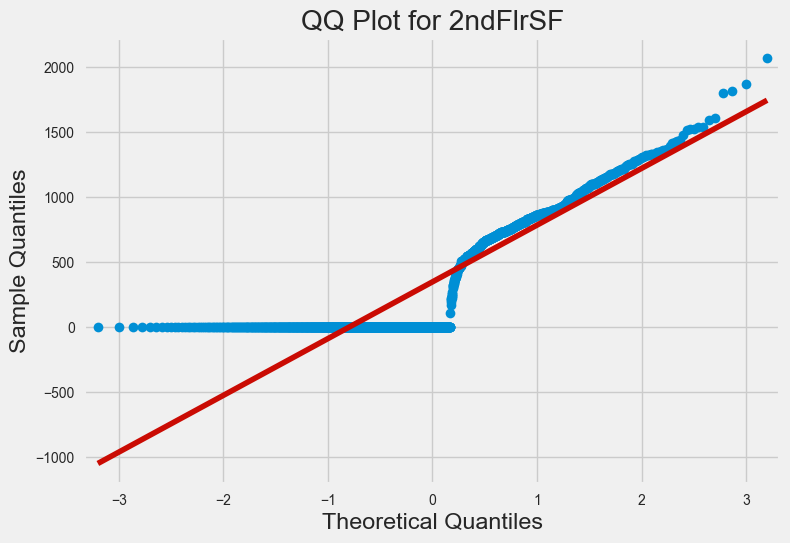

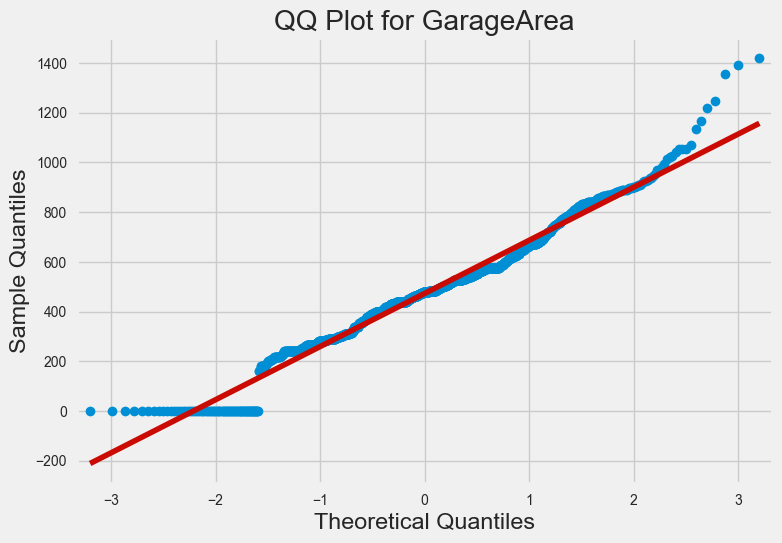

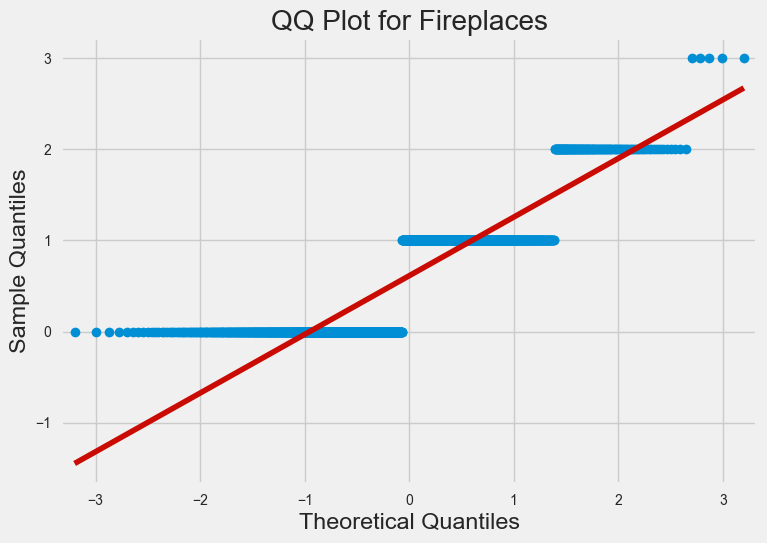

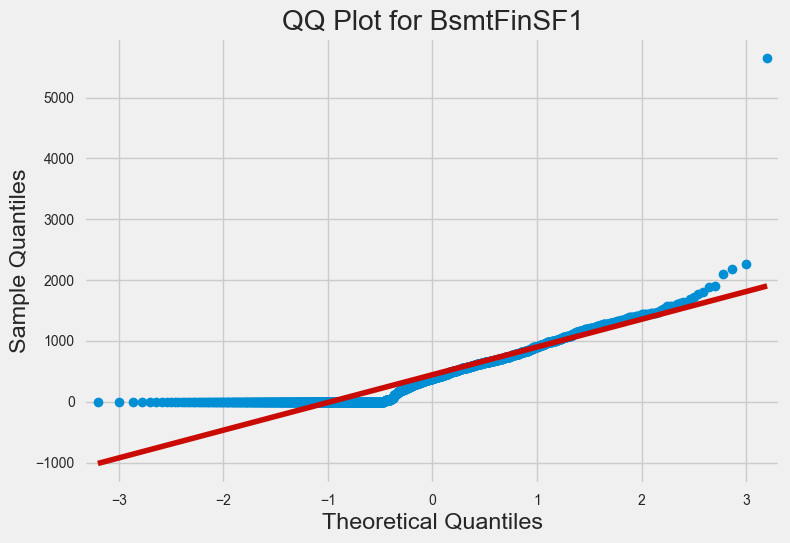

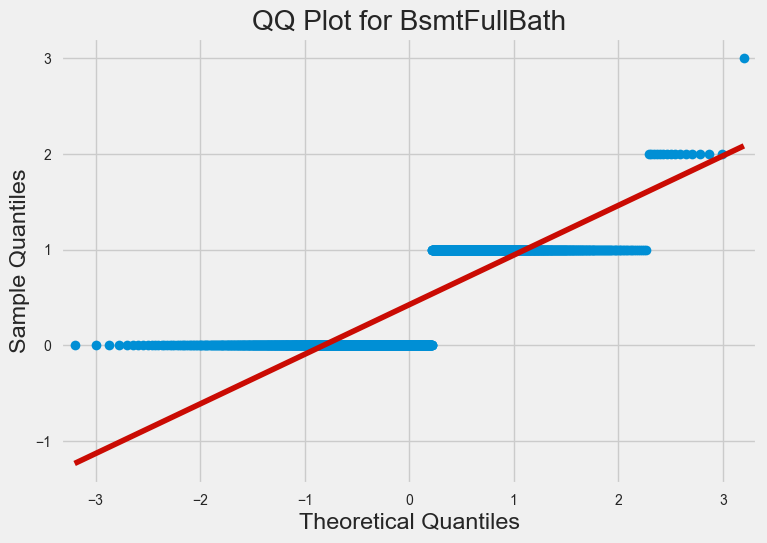

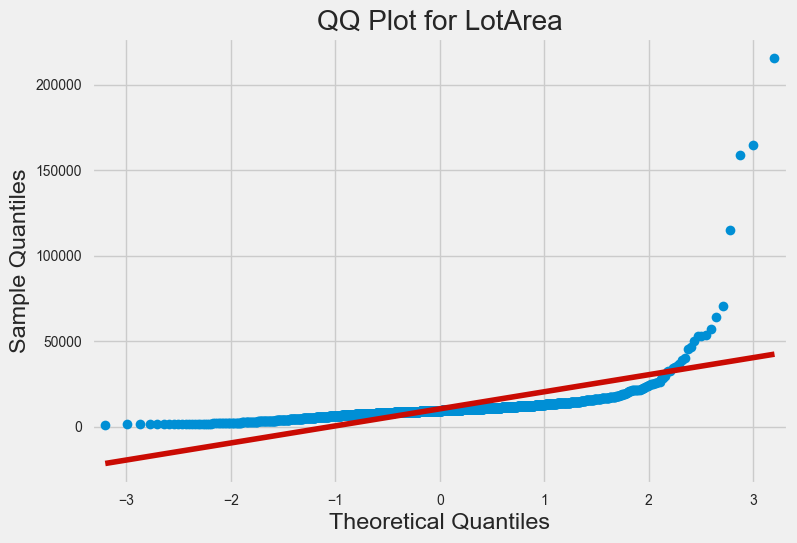

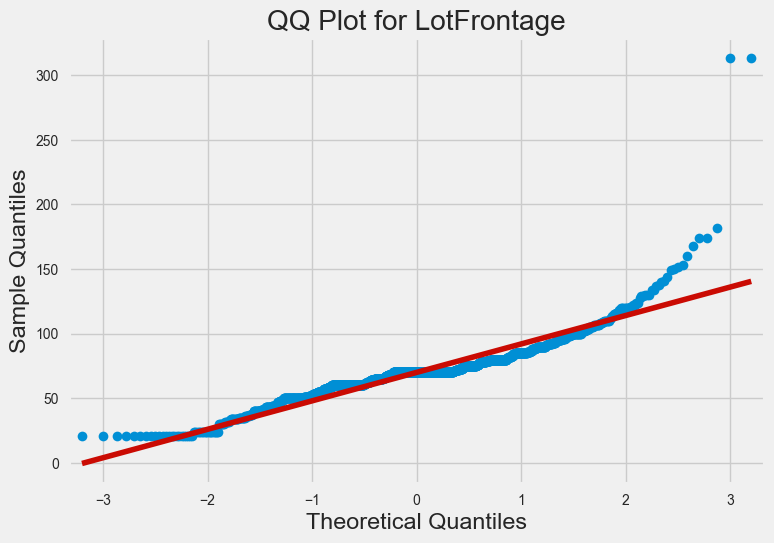

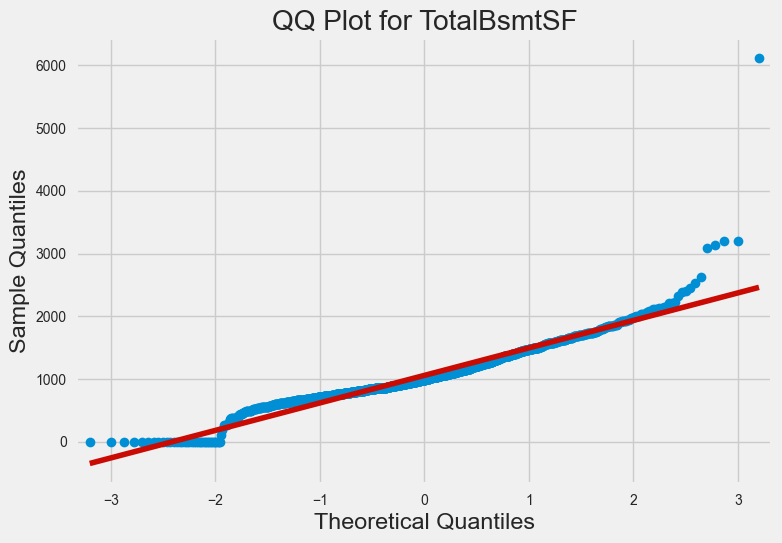

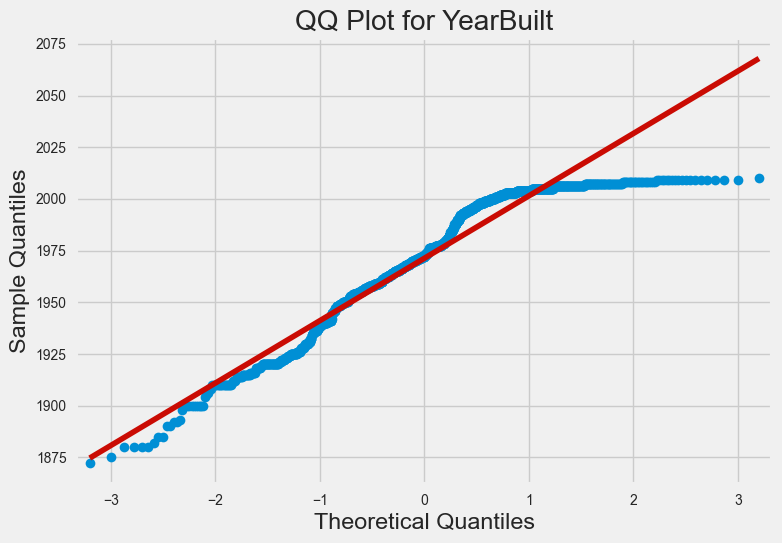

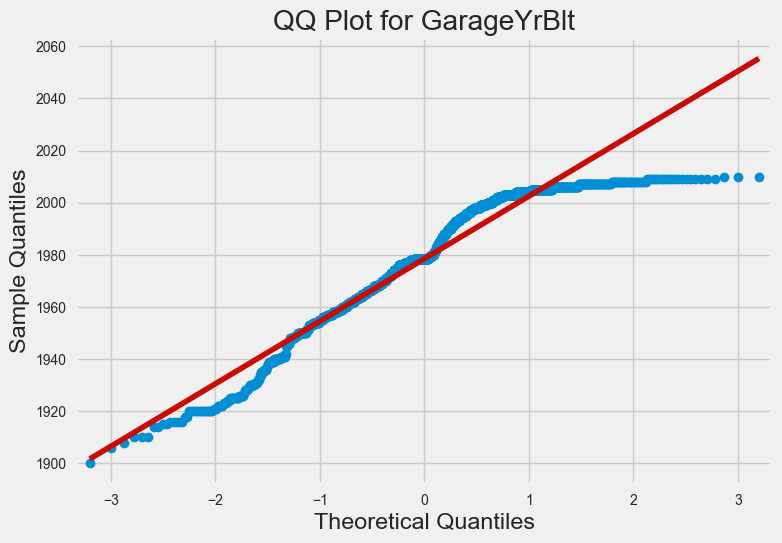

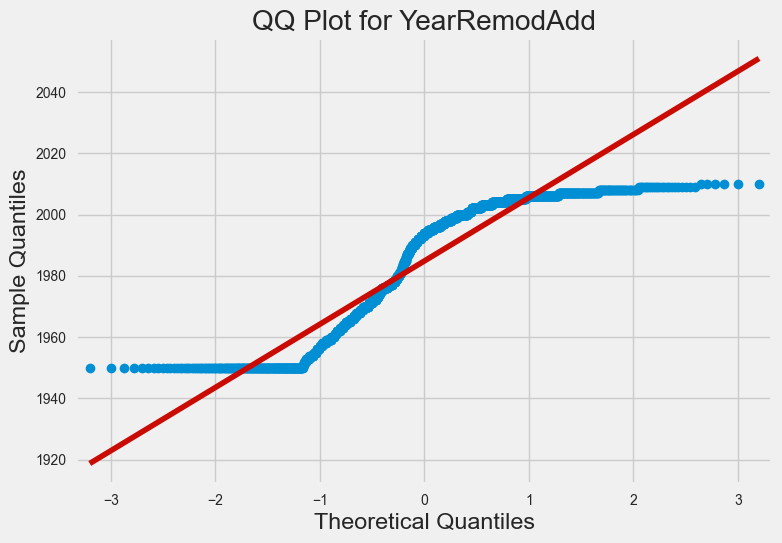

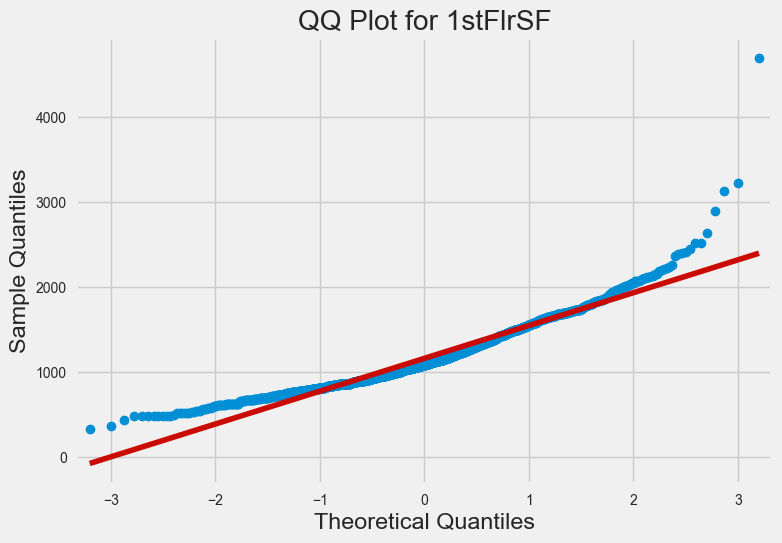

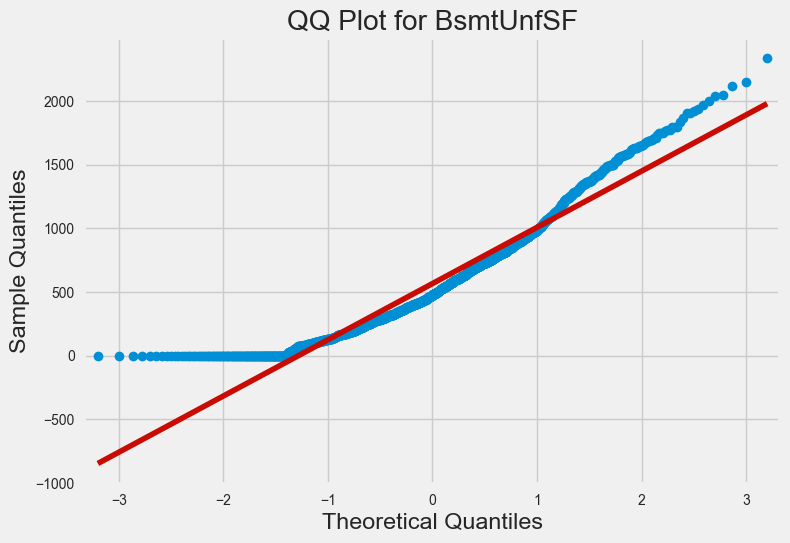

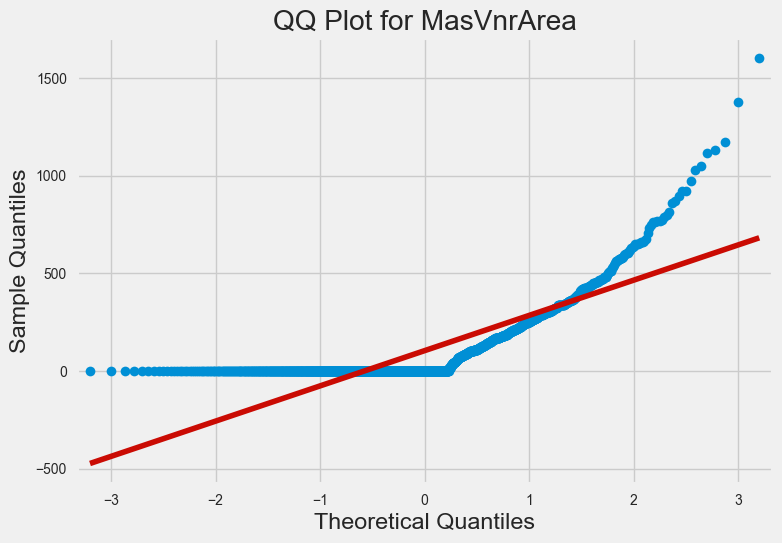

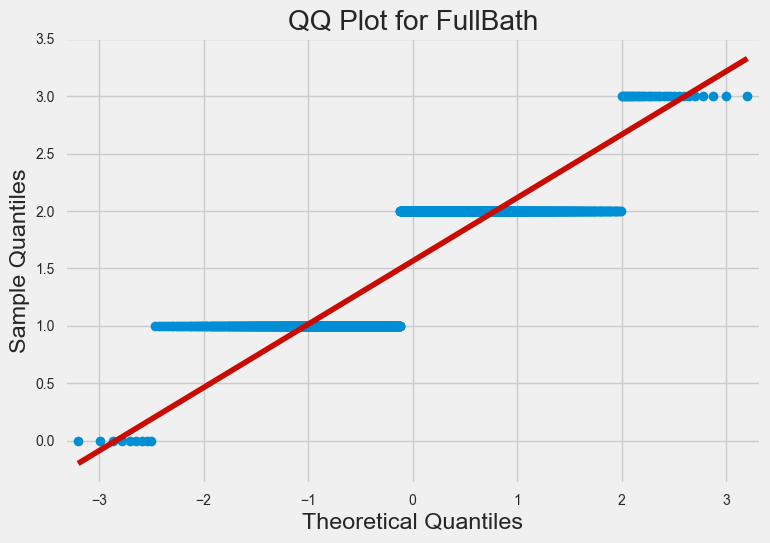

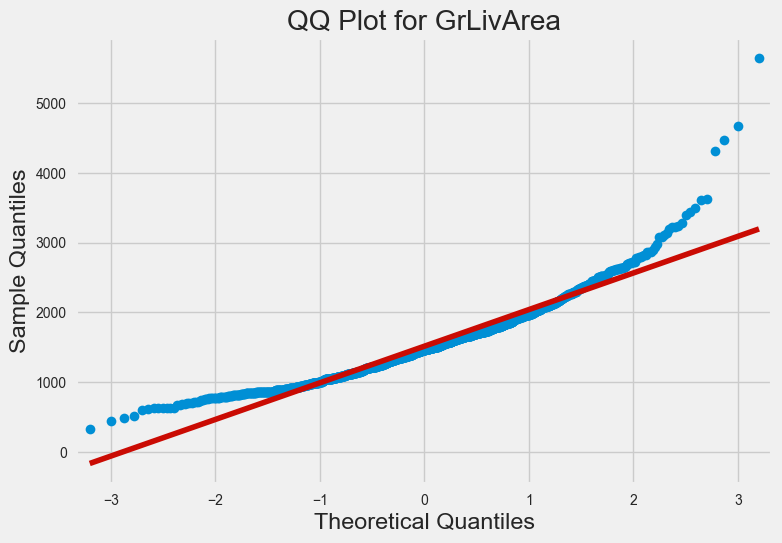

In [26]:
for column in numerical_columns:
    sm.qqplot(kaggle_house_price_df[column], line='s')
    plt.title(f'QQ Plot for {column}')
    plt.show()

<b><span style="color:blue;">Observation:-</span></b> In the QQ plot, clusters are visible in many features. Some features, such as GrLivArea, LotFrontage, TotalBsmtSF, etc., exhibit skewed normal distribution with numerous outliers.

<h3><span style="color: brown;"> Handle Categorical Data </span> </h3>

Out of the 79 features, 43 are categorical. Here’s our approach:

	1.	Explore the relationship between categorical features and the dependent (target) variable.
	2.	Determine which categorical variables to retain and which to discard.
	3.	Assess whether categorical features need conversion to numerical values based on model requirements. Note that models like CatBoost and LightGBM can handle categorical columns directly.
	4.	If conversion is necessary, decide on the encoding method, such as label encoding or one-hot encoding.

In [27]:
categorical_columns=categorical_feature_list(kaggle_house_price_df)

<h3><span style="color:green;">ANOVA Test:-</span></h3>
<ul>
    <li><b><span style="color:blue;">H0</span></b>: The mean SalePrice is the same across all categories of the categorical feature.</li>
   <li><b><span style="color:blue;">Ha</span></b>: alternative hypothesis would be that there is at least one group with a different mean SalePrice.</li></ul>
    

Output Explanation :-
    
<ul>
    <li><b><span style="color:blue;">The F-statistic measures the ratio of the variance between groups to the variance within groups:-</span></b> 
   If the F-statistic is relatively low then is suggests that the variance between groups is similar to the variance within groups. When the F-statistic is higher, it indicates that there is more variability between groups compared to within groups.</li>
   <li><b><span style="color:blue;">The p-value helps us decide whether to reject the null hypothesis and consider the column as a potential feature:-</span></b> 
  A lower p-value (typically < 0.05) indicates that the feature is likely to have a significant impact on the target variable (here SalePrice). In such cases, we can consider those columns as potential features and reject the rest of the columns.</li></ul>

In [28]:
for column in categorical_columns:
    grouped_data = [group['SalePrice'].values for name, group in kaggle_house_price_df.groupby(column)]
    anova_result = stats.f_oneway(*grouped_data)# Perform one-way ANOVA
    print(f"\nANOVA for {column} feature:")
    print("******************************************")
    print("ANOVA F-statistic:", anova_result.statistic)
    print("ANOVA p-value:", anova_result.pvalue)


ANOVA for MSZoning feature:
******************************************
ANOVA F-statistic: 43.84028167245718
ANOVA p-value: 8.817633866272648e-35

ANOVA for Street feature:
******************************************
ANOVA F-statistic: 2.4592895583691994
ANOVA p-value: 0.11704860406782483

ANOVA for Alley feature:
******************************************
ANOVA F-statistic: 15.17661388998799
ANOVA p-value: 2.9963796805460783e-07

ANOVA for LotShape feature:
******************************************
ANOVA F-statistic: 40.132851662262944
ANOVA p-value: 6.447523852011766e-25

ANOVA for LandContour feature:
******************************************
ANOVA F-statistic: 12.850188333283924
ANOVA p-value: 2.7422167521379096e-08

ANOVA for Utilities feature:
******************************************
ANOVA F-statistic: 0.29880407484898486
ANOVA p-value: 0.5847167739689381

ANOVA for LotConfig feature:
******************************************
ANOVA F-statistic: 7.80995412346779
ANOVA p-value:

<b>Categorical features which has impact on Sales Price are:- </b> MSZoning,AlleyLotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinType2,Heating,HeatingQC,Electrical,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
<b> Features we can delete:-</b>Street,Utilities,LandSlope

In [29]:
drop_columns(kaggle_house_price_df,['Street','Utilities','LandSlope'])

<h3><span style="color: brown;"> Check Categorical Columns For Encoding </span></h3> Decide what kind of encoding technique should be applied

In [30]:
kaggle_house_price_unique_count = pd.DataFrame({
    'Column Name': kaggle_house_price_df.columns,
    'Data Type': kaggle_house_price_df.dtypes.values,
    'Unique Count': kaggle_house_price_df.nunique().values
})

kaggle_house_price_unique_count[kaggle_house_price_unique_count['Data Type']==
                                'object'][['Column Name','Unique Count']]

Column Name  Unique Count
0        MSZoning             5
3           Alley             3
4        LotShape             4
5     LandContour             4
6       LotConfig             5
7    Neighborhood            25
8      Condition1             9
9      Condition2             8
10       BldgType             5
11     HouseStyle             8
15      RoofStyle             6
16       RoofMatl             8
17    Exterior1st            15
18    Exterior2nd            16
19     MasVnrType             4
21      ExterQual             4
22      ExterCond             5
23     Foundation             6
24       BsmtQual             5
25       BsmtCond             5
26   BsmtExposure             5
27   BsmtFinType1             7
29   BsmtFinType2             7
32        Heating             6
33      HeatingQC             5
34     CentralAir             2
35     Electrical             5
42    KitchenQual             4
44     Functional             7
46    FireplaceQu             6
47     GarageType             7
49   GarageFinish             4
52     GarageQual             6
53     GarageCond             6
54     PavedDrive             3
57         PoolQC             4
58          Fence             5
59    MiscFeature             5
60       SaleType             9
61  SaleCondition             6

<h3><span style="color: blue;">We can either perform encoding or choose a model that can handle categorical data automatically. We will explore both options:</span></h3>

	1.	Create a copy of the dataframe, and this duplicate will be used for encoding. The original dataframe will be employed for CatBoost and LightGBM, which do not require explicit encoding for categorical data.
	2.	On the copied dataframe, we will initially apply label encoding and subsequently attempt one-hot encoding. For this dataframe, we will utilize few traditional regression models. We will choose the best ones by performing cross validation.

In [31]:
kaggle_house_price_df_label_encoded=kaggle_house_price_df.copy()
categorical_columns=categorical_feature_list(kaggle_house_price_df_label_encoded)
kaggle_house_price_df_label_encoded[categorical_columns]

MSZoning Alley LotShape LandContour LotConfig Neighborhood Condition1  \
0          RL   N/A      Reg         Lvl    Inside      CollgCr       Norm   
1          RL   N/A      Reg         Lvl       FR2      Veenker      Feedr   
2          RL   N/A      IR1         Lvl    Inside      CollgCr       Norm   
3          RL   N/A      IR1         Lvl    Corner      Crawfor       Norm   
4          RL   N/A      IR1         Lvl       FR2      NoRidge       Norm   
...       ...   ...      ...         ...       ...          ...        ...   
1455       RL   N/A      Reg         Lvl    Inside      Gilbert       Norm   
1456       RL   N/A      Reg         Lvl    Inside       NWAmes       Norm   
1457       RL   N/A      Reg         Lvl    Inside      Crawfor       Norm   
1458       RL   N/A      Reg         Lvl    Inside        NAmes       Norm   
1459       RL   N/A      Reg         Lvl    Inside      Edwards       Norm   

     Condition2 BldgType HouseStyle  ... GarageType GarageFinish GarageQual  \
0          Norm     1Fam     2Story  ...     Attchd          RFn         TA   
1          Norm     1Fam     1Story  ...     Attchd          RFn         TA   
2          Norm     1Fam     2Story  ...     Attchd          RFn         TA   
3          Norm     1Fam     2Story  ...     Detchd          Unf         TA   
4          Norm     1Fam     2Story  ...     Attchd          RFn         TA   
...         ...      ...        ...  ...        ...          ...        ...   
1455       Norm     1Fam     2Story  ...     Attchd          RFn         TA   
1456       Norm     1Fam     1Story  ...     Attchd          Unf         TA   
1457       Norm     1Fam     2Story  ...     Attchd          RFn         TA   
1458       Norm     1Fam     1Story  ...     Attchd          Unf         TA   
1459       Norm     1Fam     1Story  ...     Attchd          Fin         TA   

     GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
0            TA          Y    N/A    N/A         N/A       WD        Normal  
1            TA          Y    N/A    N/A         N/A       WD        Normal  
2            TA          Y    N/A    N/A         N/A       WD        Normal  
3            TA          Y    N/A    N/A         N/A       WD       Abnorml  
4            TA          Y    N/A    N/A         N/A       WD        Normal  
...         ...        ...    ...    ...         ...      ...           ...  
1455         TA          Y    N/A    N/A         N/A       WD        Normal  
1456         TA          Y    N/A  MnPrv         N/A       WD        Normal  
1457         TA          Y    N/A  GdPrv        Shed       WD        Normal  
1458         TA          Y    N/A    N/A         N/A       WD        Normal  
1459         TA          Y    N/A    N/A         N/A       WD        Normal  

[1460 rows x 40 columns]

Label encoder is used when features have ordinal relationships

In [32]:
le=LabelEncoder()
for col in categorical_columns:
    kaggle_house_price_df_label_encoded[col]=le.fit_transform(kaggle_house_price_df_label_encoded[col])

In [33]:
kaggle_house_price_df_label_encoded[categorical_columns]

MSZoning  Alley  LotShape  LandContour  LotConfig  Neighborhood  \
0            3      1         3            3          4             5   
1            3      1         3            3          2            24   
2            3      1         0            3          4             5   
3            3      1         0            3          0             6   
4            3      1         0            3          2            15   
...        ...    ...       ...          ...        ...           ...   
1455         3      1         3            3          4             8   
1456         3      1         3            3          4            14   
1457         3      1         3            3          4             6   
1458         3      1         3            3          4            12   
1459         3      1         3            3          4             7   

      Condition1  Condition2  BldgType  HouseStyle  ...  GarageType  \
0              2           2         0           5  ...           1   
1              1           2         0           2  ...           1   
2              2           2         0           5  ...           1   
3              2           2         0           5  ...           5   
4              2           2         0           5  ...           1   
...          ...         ...       ...         ...  ...         ...   
1455           2           2         0           5  ...           1   
1456           2           2         0           2  ...           1   
1457           2           2         0           5  ...           1   
1458           2           2         0           2  ...           1   
1459           2           2         0           2  ...           1   

      GarageFinish  GarageQual  GarageCond  PavedDrive  PoolQC  Fence  \
0                2           5           5           2       3      4   
1                2           5           5           2       3      4   
2                2           5           5           2       3      4   
3                3           5           5           2       3      4   
4                2           5           5           2       3      4   
...            ...         ...         ...         ...     ...    ...   
1455             2           5           5           2       3      4   
1456             3           5           5           2       3      2   
1457             2           5           5           2       3      0   
1458             3           5           5           2       3      4   
1459             0           5           5           2       3      4   

      MiscFeature  SaleType  SaleCondition  
0               1         8              4  
1               1         8              4  
2               1         8              4  
3               1         8              0  
4               1         8              4  
...           ...       ...            ...  
1455            1         8              4  
1456            1         8              4  
1457            3         8              4  
1458            1         8              4  
1459            1         8              4  

[1460 rows x 40 columns]

One-hot encoding is used when dealing with categorical variables that don’t have an inherent ordinal relationship between their different categories.

In [34]:
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(kaggle_house_price_df[categorical_columns]).toarray()
encoded_column_names = encoder.get_feature_names_out(categorical_columns)
kaggle_encoded = pd.DataFrame(encoded_data, columns=encoded_column_names)

kaggle_house_price_df_one_hot_encoded = pd.concat([kaggle_house_price_df[numerical_columns], kaggle_encoded, 
                                                   kaggle_house_price_df['SalePrice']], axis=1)

kaggle_house_price_df_one_hot_encoded

OverallQual  WoodDeckSF  HalfBath  TotRmsAbvGrd  OpenPorchSF  \
0               7           0         1             8           61   
1               6         298         0             6            0   
2               7           0         1             6           42   
3               7           0         0             7           35   
4               8         192         1             9           84   
...           ...         ...       ...           ...          ...   
1455            6           0         1             7           40   
1456            6         349         0             7            0   
1457            7           0         0             9           60   
1458            5         366         0             5            0   
1459            5         736         1             6           68   

      GarageCars  2ndFlrSF  GarageArea  Fireplaces  BsmtFinSF1  ...  \
0              2       854         548           0         706  ...   
1              2         0         460           1         978  ...   
2              2       866         608           1         486  ...   
3              3       756         642           1         216  ...   
4              3      1053         836           1         655  ...   
...          ...       ...         ...         ...         ...  ...   
1455           2       694         460           1           0  ...   
1456           2         0         500           2         790  ...   
1457           1      1152         252           2         275  ...   
1458           1         0         240           0          49  ...   
1459           1         0         276           0         830  ...   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0.00          0.00         1.00                   0.00   
1             0.00          0.00         1.00                   0.00   
2             0.00          0.00         1.00                   0.00   
3             0.00          0.00         1.00                   1.00   
4             0.00          0.00         1.00                   0.00   
...            ...           ...          ...                    ...   
1455          0.00          0.00         1.00                   0.00   
1456          0.00          0.00         1.00                   0.00   
1457          0.00          0.00         1.00                   0.00   
1458          0.00          0.00         1.00                   0.00   
1459          0.00          0.00         1.00                   0.00   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0.00                  0.00                  0.00   
1                      0.00                  0.00                  0.00   
2                      0.00                  0.00                  0.00   
3                      0.00                  0.00                  0.00   
4                      0.00                  0.00                  0.00   
...                     ...                   ...                   ...   
1455                   0.00                  0.00                  0.00   
1456                   0.00                  0.00                  0.00   
1457                   0.00                  0.00                  0.00   
1458                   0.00                  0.00                  0.00   
1459                   0.00                  0.00                  0.00   

      SaleCondition_Normal  SaleCondition_Partial  SalePrice  
0                     1.00                   0.00     208500  
1                     1.00                   0.00     181500  
2                     1.00                   0.00     223500  
3                     0.00                   0.00     140000  
4                     1.00                   0.00     250000  
...                    ...                    ...        ...  
1455                  1.00                   0.00     175000  
1456                  1.00                

<h3><span style="color:brown;">Feature Engineering</span></h3>

Prior to proceeding to the next step, manually examine whether any feature engineering is feasible to minimize the number of features.

# Step 3:- Find Correct Model

<h1><span style="color: Red;"> 1. Models which can handle Categorical Features</span></h1>

<h2><span style="color:green;">Cat Boost</span></h2>

<h3><span style="color: brown;"> Features </span> </h3> Split the data into train and test set

In [35]:
golden_features=[col for col in kaggle_house_price_df.columns if col != 'SalePrice']

In [36]:
X=kaggle_house_price_df[golden_features]
y=kaggle_house_price_df['SalePrice']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=random_seed)

categorical_features = [kaggle_house_price_df.columns.get_loc(col) for col in 
                        kaggle_house_price_df.columns if kaggle_house_price_df[col].dtype == 'object']

<h3><span style="color: brown;"> Hyper-parameter Tuning </span> </h3> Comment it out after one run and paste the output in the next cell

<b><span style="color:pink;">Actual Model</span>

In [37]:
best_params = {'depth': 10, 'iterations': 500, 'learning_rate': 0.01}

In [38]:
cat_model = CatBoostRegressor(cat_features=categorical_features, **best_params, random_seed=random_seed, verbose=0,  task_type='CPU')

# Train the model on the training data
cat_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = cat_model.predict(X_val)

# Evaluate the model performance
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f'R^2 Score: {r2}')
print(f'Root Mean Squared Error: {rmse}')

R^2 Score: 0.8771209143222848
Root Mean Squared Error: 29249.250327798774


<b><span style="color:pink;">Check importance score for each feature</span>

In [39]:
cat_model.get_feature_importance()

array([ 0.68512112,  0.28629898,  3.18501904,  0.24383144,  0.51387951,
        0.87814841,  0.25080999,  2.48934386,  0.83515714,  0.20650991,
        0.84401833,  0.52697237, 20.09073502,  0.53611493,  1.28346254,
        0.49997416,  0.24465898,  0.28440353,  0.20751195,  0.62299067,
        0.26684196,  2.54385872,  0.05780823,  0.17085093,  4.07706617,
        0.36155011,  1.77765606,  0.70191741,  4.27411802,  0.07513001,
        0.21222522,  2.9070433 ,  0.07736308,  0.92906091,  0.37900471,
        0.2159676 ,  4.31539666,  2.49306751, 13.86978232,  0.64829338,
        1.1032891 ,  0.70508759,  3.1324853 ,  1.58550012,  0.07164585,
        1.46121149,  2.87461304,  1.9498311 ,  0.39293541,  2.85100871,
        4.03137781,  0.96625431,  0.24387733,  0.27988108,  0.33149668,
        0.3927635 ,  0.61759448,  0.10301637,  0.1500723 ,  0.1768846 ,
        0.65772333,  0.85248631])

<h2><span style="color:green;">Light GBM</span></h2>

Let's now experiment with  <b><span style="color: brown;"> Light GBM </span> </b> and determine if it outperforms CatBoost.

In [40]:
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

<h3><span style="color: brown;"> Hyper-parameter Tuning </span> </h3> Comment it out after one run and paste the output in the next cell

<b><span style="color:pink;">Actual Model</span>

In [41]:
gbm_best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 20,
    'num_iterations':500,
    'n_estimators': 100, 
    'learning_rate':0.01,
    'deterministic':True,
    'verbose': -1,  
} #Generated using the hyperparameter values specified in the code above.

In [42]:
train_data=lightgbm.Dataset(X_train,label=y_train,categorical_feature=categorical_columns)
valid_data=lightgbm.Dataset(X_val,label=y_val,categorical_feature=categorical_columns)

lightgbm_model = lightgbm.train(gbm_best_params, train_data, num_boost_round=1000, valid_sets=[train_data,valid_data])
# Make predictions
y_pred = lightgbm_model.predict(X_val, num_iteration=lightgbm_model.best_iteration)

# Evaluate the model
r2_val=r2_score(y_val,y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'R2: {r2_val}')
print(f'RMSE: {rmse}')

R2: 0.7100097509441067
RMSE: 44933.21060513518


<b><span style="color:pink;">Check importance score for each feature</span>

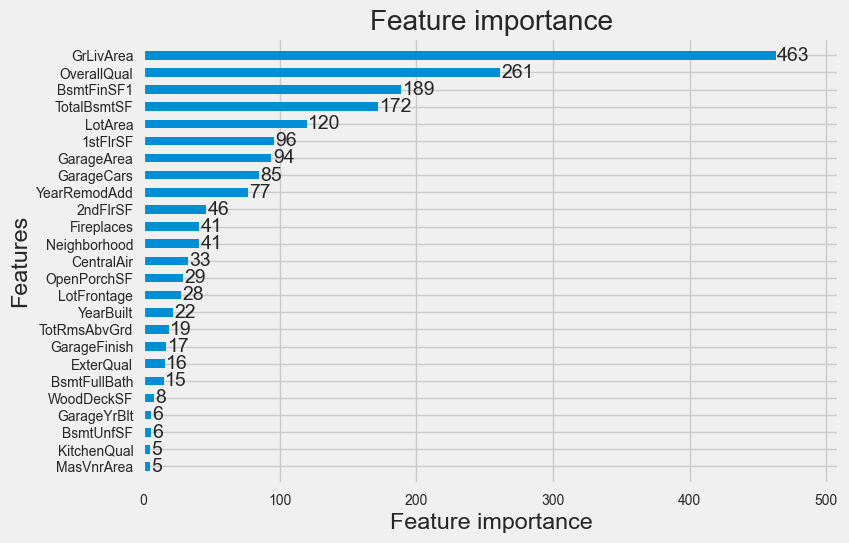

In [43]:
lightgbm.plot_importance(lightgbm_model,height=0.5,precision=100,max_num_features=25);

<h1><span style="color:green;">Traditional Models</span></h1>No categorical columns

<h1><span style="color: Red;"> 2. Models which can not handle Categorical Features</span></h1><u><b>Using Label Encoding</b></u>

In [44]:
X=kaggle_house_price_df_label_encoded.drop('SalePrice',axis=1)
y=kaggle_house_price_df_label_encoded['SalePrice']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=random_seed)

<h3><span style="color: brown;"> Cross Validation to select best model </span> </h3>

In [45]:
#Create a list of models to evaluate.
models = [LinearRegression(), Lasso(), Ridge(), KNeighborsRegressor(), SVR(), 
          DecisionTreeRegressor(), RandomForestRegressor()]

#Iterate over the models and evaluate their performance using cross-validation.
for model in models:
    model_name=type(model).__name__
    rmse_scores= cross_val_score(model,X,y,cv=5,scoring='neg_root_mean_squared_error')
    avg_rmse_score=-rmse_scores.mean()
    r2_val= cross_val_score(model,X,y,cv=5,scoring='r2')
    avg_r2_score=r2_val.mean()
    
    print(f'{model_name} - Average RMSE Score: {avg_rmse_score} and R2 Score: {avg_r2_score}')

LinearRegression - Average RMSE Score: 34631.94888881793 and R2 Score: 0.8038363398725801
Lasso - Average RMSE Score: 34629.00599622588 and R2 Score: 0.8038705925156762
Ridge - Average RMSE Score: 34597.531201493155 and R2 Score: 0.8042286117202684
KNeighborsRegressor - Average RMSE Score: 46756.81946499743 and R2 Score: 0.6509153046074727
SVR - Average RMSE Score: 81143.56008683398 and R2 Score: -0.0514812808796913
DecisionTreeRegressor - Average RMSE Score: 37778.823475563186 and R2 Score: 0.7378588812421423
RandomForestRegressor - Average RMSE Score: 29416.804356909743 and R2 Score: 0.8642071551804165


<h3><span style="color:brown;">We will go ahead with Linear Regression and Random Forest Regressor

<h2><span style="color:green;">Linear Regression</span></h2>

In [46]:
lin_label_model=LinearRegression().fit(X_train,y_train)
y_pred = lin_label_model.predict(X_val)

<h3><span style="color: brown;"> Feature Importance </span> </h3>

In [47]:
lin_label_model.coef_

array([-1.92391519e+03, -2.48537861e+02,  3.98344428e-01,  9.48556164e+02,
       -1.56252128e+03,  2.03777614e+03,  1.99393408e+02,  3.25932350e+02,
       -4.46473830e+02, -9.72101771e+03, -7.22585158e+03, -2.48299751e+03,
        1.26650782e+04,  1.12667646e+02,  1.78516018e+02,  3.52036112e+03,
        5.47150320e+03, -1.42777185e+03,  6.95000868e+02,  3.90895796e+03,
        2.72431464e+01, -8.48861374e+03, -6.88781708e+01,  5.96976996e+02,
       -5.36529309e+03,  2.86239579e+03, -2.91574325e+03, -1.05822773e+03,
       -4.72876876e+00,  7.60550392e+02, -1.09276726e+01,  7.89494340e+00,
       -1.87772115e+03, -2.76039353e+02,  8.15843654e+03,  1.81555822e+02,
        3.09515879e+01,  2.59647163e+01,  1.39809110e+01,  6.86278339e+03,
        1.45184194e+03,  7.90836750e+02, -9.69976747e+03,  1.70409168e+03,
        4.35287950e+03,  6.42428845e+03, -9.52084257e+02, -9.34506921e+00,
       -5.19902094e+01, -1.42573675e+03,  1.17342504e+04,  1.61942524e+00,
       -1.30642411e+03,  

In [48]:
print_prediction(y_val,y_pred).head(10)

Actual  Predicted
0  154500  143276.62
1  325000  314179.52
2  115000  111790.93
3  159000  178241.78
4  315500  326992.27
5   75500   66030.69
6  311500  234581.84
7  146000  147540.21
8   84500   72421.38
9  135500  132479.15

In [49]:
rmse_val=np.sqrt(mean_squared_error(y_val, y_pred))
r2_val=r2_score(y_val, y_pred)
print("rmse= ",rmse_val," and r2_score= ",r2_val)

rmse=  34383.13321207915  and r2_score=  0.8458735890043563


In [50]:
rmse_lin_reg,r2_lin_reg=residual_check(y_val,y_pred)

rmse=  34383.13321207915  and r2_score=  0.8458735890043563


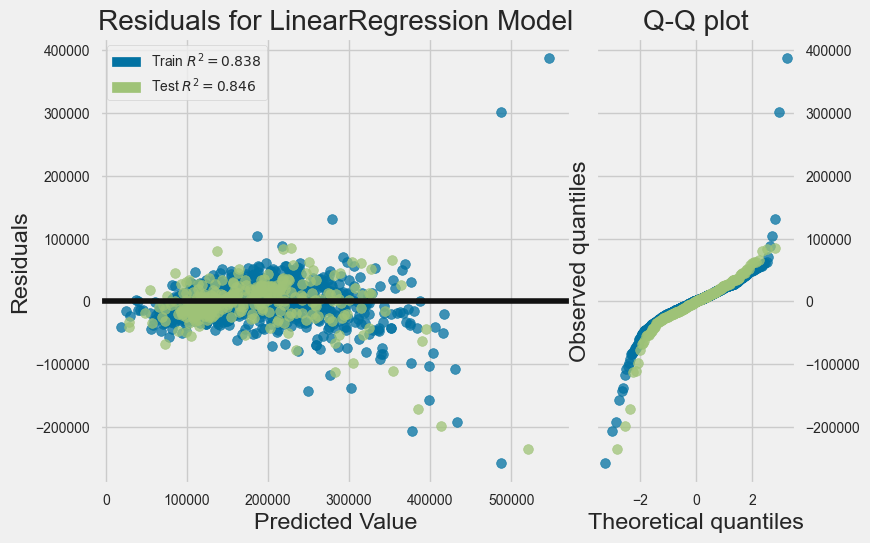

In [51]:
# Residuals Plot
visualizer_residuals = ResidualsPlot(lin_label_model,hist=False,qqplot=True)
visualizer_residuals.fit(X_train, y_train)
visualizer_residuals.score(X_val, y_val)
visualizer_residuals.show()
plt.show()

<h2><span style="color:green;">Random Forest</span></h2>

<b><span style="color:pink;">Hyperparameter Tuning</span>

In [52]:
# Define the range of values for the n_estimators hyperparameter
param_grid_random_forest = {'n_estimators': [10, 50, 100, 150, 200]}

gscv_random_forest = GridSearchCV( RandomForestRegressor(), param_grid=param_grid_random_forest, cv=5, scoring="r2")
gscv_random_forest.fit(X_train,y_train)

print("Best n_estimators:", gscv_random_forest.best_params_["n_estimators"])

Best n_estimators: 100


In [53]:
random_forest_label_model = RandomForestRegressor(n_estimators=gscv_random_forest.best_params_["n_estimators"], random_state=random_seed).fit(X_train,y_train)
y_pred = random_forest_label_model.predict(X_val)

In [54]:
random_forest_label_model.feature_importances_

array([1.39630684e-03, 8.67678344e-03, 1.89693036e-02, 1.92233644e-04,
       1.86288014e-03, 1.84122125e-03, 7.77717247e-04, 9.68825389e-03,
       1.12717534e-03, 3.62434334e-04, 8.23116747e-04, 7.95295897e-04,
       5.58585237e-01, 1.30771281e-02, 7.68479430e-03, 1.15319041e-03,
       1.99429415e-04, 1.65338793e-03, 1.42769795e-03, 1.05056434e-03,
       3.85758654e-03, 2.25621570e-03, 4.26298194e-04, 6.33656104e-04,
       7.20654522e-03, 7.46031999e-04, 2.76173207e-03, 1.66503378e-03,
       2.88797094e-02, 1.16242312e-03, 5.92793013e-03, 3.54478929e-02,
       1.62166690e-04, 9.84579916e-04, 3.95479974e-03, 1.98875652e-04,
       2.75921173e-02, 3.52341429e-02, 1.23648154e-01, 9.60045583e-04,
       5.77224857e-03, 1.23973797e-03, 3.48794317e-03, 7.48431530e-03,
       6.02526681e-04, 3.29563318e-03, 1.87612614e-03, 6.91463270e-03,
       6.99934885e-03, 1.39630961e-03, 1.20777936e-02, 1.62574232e-02,
       8.99195177e-04, 3.80378573e-04, 3.44241756e-04, 5.44648227e-03,
      

In [55]:
print_prediction(y_val,y_pred).head(10)

Actual  Predicted
0  154500  139999.25
1  325000  328632.22
2  115000  116323.25
3  159000  161033.40
4  315500  325264.65
5   75500   86057.58
6  311500  213901.49
7  146000  151471.75
8   84500   86338.66
9  135500  127373.35

In [56]:
rmse_random_forest,r2_random_forest=residual_check(y_val,y_pred)

rmse=  28367.967239203685  and r2_score=  0.8950837886750517


<h1><span style="color: Red;"> 3. Models which can not handle Categorical Features</span></h1><u><b>Using One Hot Encoding</b></u>

In [57]:
X=kaggle_house_price_df_one_hot_encoded.drop('SalePrice',axis=1)
y=kaggle_house_price_df_one_hot_encoded['SalePrice']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=random_seed)

<h3><span style="color: brown;"> Cross Validation to select best model </span> </h3>

In [58]:
#Create a list of models to evaluate.
models = [LinearRegression(), Lasso(), Ridge(), KNeighborsRegressor(), SVR(), 
          DecisionTreeRegressor(), RandomForestRegressor()]

#Iterate over the models and evaluate their performance using cross-validation.
for model in models:
    model_name=type(model).__name__
    rmse_scores= cross_val_score(model,X,y,cv=5,scoring='neg_root_mean_squared_error')
    avg_rmse_score=-rmse_scores.mean()
    r2_val= cross_val_score(model,X,y,cv=5,scoring='r2')
    avg_r2_score=r2_val.mean()
    
    print(f'{model_name} - Average RMSE Score: {avg_rmse_score} and R2 Score: {avg_r2_score}')

LinearRegression - Average RMSE Score: 35251.37964665763 and R2 Score: 0.7984013611456298
Lasso - Average RMSE Score: 34633.932626981514 and R2 Score: 0.80524425326469
Ridge - Average RMSE Score: 32544.18471370165 and R2 Score: 0.826540250278996
KNeighborsRegressor - Average RMSE Score: 46756.81946499743 and R2 Score: 0.6509153046074727
SVR - Average RMSE Score: 81143.8414441919 and R2 Score: -0.051488604643972605
DecisionTreeRegressor - Average RMSE Score: 39156.60864038577 and R2 Score: 0.7210873651235996
RandomForestRegressor - Average RMSE Score: 29586.832514901995 and R2 Score: 0.8573246494231025


<h3><span style="color:brown;">We will go ahead with Ridge Regression and Random Forest Regressor

<h2><span style="color:green;">Ridge Regression</span></h2>

In [59]:
ridge_one_hot_model=Ridge(alpha=0.1).fit(X_train,y_train)
pred_y=ridge_one_hot_model.predict(X_val)

<h3><span style="color: brown;"> Feature Importance </span> </h3>

In [60]:
ridge_one_hot_model.coef_

array([ 7.58285401e+03,  1.69826312e+01,  2.48230506e+03,  1.20294857e+03,
        4.90589097e+00,  3.60876830e+03,  4.97567756e+01,  2.73497044e+01,
        6.19592881e+03,  9.36773037e+00,  1.76280711e+03,  3.71451305e-01,
       -3.11722740e+01,  2.27345092e+01,  2.05593208e+02, -6.60347489e+01,
        2.39446271e+02,  3.38491498e+01, -6.06025477e+00,  2.06356334e+01,
        2.66881526e+03,  6.39539168e+00, -2.31255774e+04,  1.14449030e+04,
        2.81719930e+03,  4.15157982e+03,  4.71189536e+03,  1.41348830e+03,
       -2.47516952e+03,  1.06168122e+03, -2.72095123e+03,  5.53331594e+03,
       -7.23802057e+02, -2.08856265e+03, -6.38290088e+03,  1.15435805e+04,
       -6.54051481e+03,  1.37983521e+03,  3.81606092e+03,  1.41928088e+04,
       -4.60628874e+03, -1.63363907e+04,  2.93380969e+03,  8.28242994e+03,
        3.31523458e+02, -2.53784400e+03,  4.46565744e+02, -9.11646005e+03,
       -6.99066690e+03,  1.67553253e+04, -1.42983603e+04, -6.88836857e+03,
       -1.13329603e+04, -

In [61]:
print_prediction(y_val,y_pred).head(10)

Actual  Predicted
0  154500  139999.25
1  325000  328632.22
2  115000  116323.25
3  159000  161033.40
4  315500  325264.65
5   75500   86057.58
6  311500  213901.49
7  146000  151471.75
8   84500   86338.66
9  135500  127373.35

In [62]:
rmse_lin_reg,r2_lin_reg=residual_check(y_val,y_pred)

rmse=  28367.967239203685  and r2_score=  0.8950837886750517


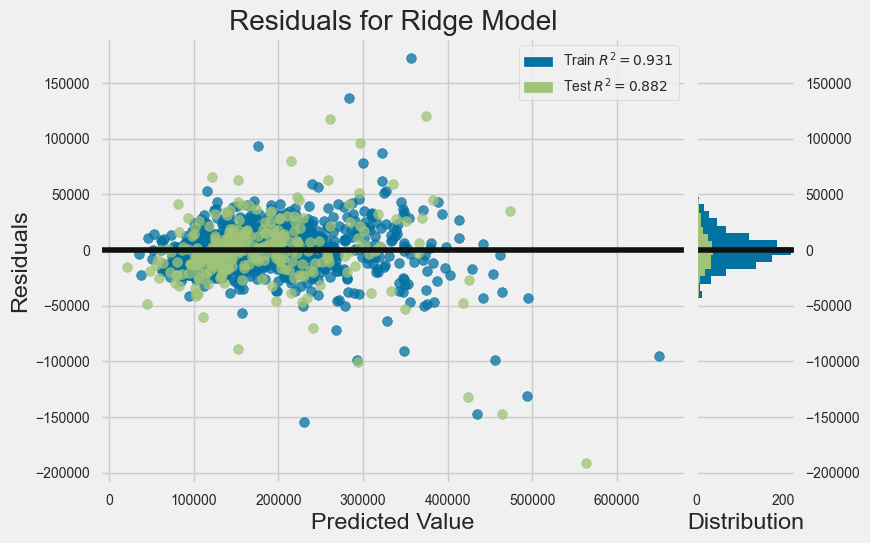

In [63]:
# Residuals Plot
visualizer_residuals = ResidualsPlot(ridge_one_hot_model)
visualizer_residuals.fit(X_train, y_train)
visualizer_residuals.score(X_val, y_val)
visualizer_residuals.show()
plt.show()

<h2><span style="color:green;">Random Forest</span></h2>

<b><span style="color:pink;">Hyperparameter Tuning</span>

In [64]:
# Define the range of values for the n_estimators hyperparameter
param_grid_random_forest = {'n_estimators': [10, 50, 100, 150, 200]}

gscv_random_forest = GridSearchCV( RandomForestRegressor(), param_grid=param_grid_random_forest, cv=5, scoring="r2")
gscv_random_forest.fit(X_train,y_train)

print("Best n_estimators:", gscv_random_forest.best_params_["n_estimators"])

Best n_estimators: 100


In [65]:
random_forest_one_hot_model = RandomForestRegressor(n_estimators=gscv_random_forest.best_params_["n_estimators"], random_state=random_seed).fit(X_train,y_train)
y_pred = random_forest_one_hot_model.predict(X_val)

In [66]:
random_forest_one_hot_model.feature_importances_

array([5.58220548e-01, 4.93344623e-03, 1.01333460e-03, 7.01903303e-03,
       6.18695809e-03, 1.21336346e-02, 3.44891164e-02, 1.61015272e-02,
       2.17097922e-03, 2.90618725e-02, 1.04889088e-03, 1.84307031e-02,
       8.30567372e-03, 3.55517696e-02, 1.28234034e-02, 6.04007677e-03,
       6.86090358e-03, 2.74125544e-02, 5.45319200e-03, 3.46206241e-03,
       5.88830508e-03, 1.23223615e-01, 3.40714794e-05, 6.96747164e-05,
       5.71245339e-05, 4.52839174e-04, 9.46412880e-04, 1.00948106e-04,
       5.93463169e-04, 2.17804395e-05, 3.35114451e-04, 4.69039952e-04,
       3.44294999e-04, 1.69035057e-03, 1.30166573e-03, 3.19098824e-04,
       5.15484314e-05, 5.75512288e-04, 4.06169326e-04, 7.74322126e-04,
       4.39859041e-05, 8.67416496e-05, 5.21073558e-04, 1.66404418e-05,
       2.20748309e-06, 1.07835137e-06, 7.29505630e-05, 2.00154512e-04,
       2.33574224e-04, 6.52185710e-04, 2.35304110e-04, 1.37888842e-04,
       4.32733960e-05, 7.57790064e-06, 3.25159242e-05, 3.57823280e-04,
      

In [67]:
print_prediction(y_val,y_pred).head(10)

Actual  Predicted
0  154500  140498.25
1  325000  330783.75
2  115000  114852.25
3  159000  150257.50
4  315500  325320.16
5   75500   85075.50
6  311500  205886.77
7  146000  151108.45
8   84500   84192.00
9  135500  125410.74

In [68]:
rmse_random_forest,r2_random_forest=residual_check(y_val,y_pred)

rmse=  29204.989694503638  and r2_score=  0.8888011539513321


<h1><span style="color: blue;"> Conclusion:- </span></h1>
As we examine the results from various models and exploratory data analysis (EDA), it becomes apparent that all models yield similar outcomes. In such scenarios, opting for the simplest or most maintainable model is a prudent choice. Let’s delve into the strengths and limitations of each model::
<ol>
    <li><b>Label Encoding:</b></li>
    <ul>
        <li>Linear Regression:</li>Explains 84.5% of the target variable, easy to implement and maintain. However, it may struggle with complex relationships and sensitivity to outliers.
        <li>Random Forest:</li>Explains 89.5% of the target variable, computationally inexpensive. Yet, challenges may arise if the ordering of columns varies in the test data.
    </ul>
    <li><b>One-Hot Encoding:</b></li>
    <ul>
        <li>Ridge Regression:</li>Performs well, explaining 89.5% of the target variables. However, challenges may arise if categorical features in the test data differ. It’s simpler and handles outliers efficiently. < Check below to understand the complexity of implementation on test data>
        <li>Random Forest:</li>A strong performer, but Ridge Regression’s simplicity and efficient handling of outliers make it a preferable choice for one-hot encoding.
    </ul>
    <li><b>Can Handle Both Numerical and Categorical Data Efficiently:</b></li>
    <ul>
        <li>CatBoost:</li>Efficiently handles categorical data without special preprocessing. Explains 87.71% of the target variables but is slower compared to other models mentioned here.
        <li>LightGBM:</li>Demonstrates excellent performance, explaining 89.8% of the target variables. It is faster than CatBoost and handles categorical data efficiently but is CPU-intensive.
    </ul>
</ol>
<h2><span style="color: red;"> Final Verdict:- </span></h2><br>
Considering the trade-offs, I will choose LightGBM if resources are not a constraint. However, if resources are limited, Random Forest (Label Encoding) stands out as a practical and efficient choice. In the final model exploration with test data, I will consider CatBoost, Ridge Regression (one-hot encoding), and LightGBM to assess their performance.

# Try the selected models (Ridge and CatBoost) on test data

In [69]:
kaggle_test_house_price_df=pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')
kaggle_test_house_price_df.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH        80.00    11622   Pave   NaN      Reg   
1  1462          20       RL        81.00    14267   Pave   NaN      IR1   
2  1463          60       RL        74.00    13830   Pave   NaN      IR1   
3  1464          60       RL        78.00     9978   Pave   NaN      IR1   
4  1465         120       RL        43.00     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [70]:
kaggle_test_house_price_df.shape

(1459, 80)

<h2><span style="color:green;">Cat Boost</span></h2>

Repeat same preprocessing we did on train data

<h3> CatBoost does not accept NaN values so lets fix it

In [71]:
handle_missing_data(kaggle_test_house_price_df)

In [72]:
preprocessing_remainder(kaggle_test_house_price_df)

Check missing value counts

In [73]:
kaggle_null_count = pd.DataFrame({
    'Column Name': kaggle_test_house_price_df.columns,
    'Data Type': kaggle_test_house_price_df.dtypes.values,
    'Null Count': kaggle_test_house_price_df.isnull().sum().values
})

kaggle_null_count[kaggle_null_count['Null Count'] > 0].sort_values(by=['Data Type','Null Count'])

Column Name Data Type  Null Count
36    BsmtFinSF2   float64           1
48  BsmtHalfBath   float64           2

In [74]:
X_ids=kaggle_test_house_price_df['Id']
X_test=kaggle_test_house_price_df[golden_features]
predictions = cat_model.predict(X_test)

submission_df = pd.DataFrame({'Id': X_ids, 'SalePrice': predictions})
submission_df.head(5)

Id  SalePrice
0  1461  118673.53
1  1462  152288.80
2  1463  183179.52
3  1464  183048.71
4  1465  201301.55

<h3><span style="color:brown;">Submit Final Output

In [75]:
submission = pd.read_csv('../data/house-prices-advanced-regression-techniques/sample_submission.csv')
submission['SalePrice'] = predictions
submission.to_csv('../data/house-prices-advanced-regression-techniques/submission_catboost.csv', index=False)
submission.head(5)

Id  SalePrice
0  1461  118673.53
1  1462  152288.80
2  1463  183179.52
3  1464  183048.71
4  1465  201301.55

<h2><span style="color:green;">Ridge Regression</span></h2>

Repeat same preprocessing we did on train data

In [76]:
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(kaggle_test_house_price_df[categorical_columns]).toarray()
encoded_column_names = encoder.get_feature_names_out(categorical_columns)
kaggle_encoded = pd.DataFrame(encoded_data, columns=encoded_column_names)

kaggle_test_price_df_one_hot_encoded = pd.concat([kaggle_test_house_price_df[numerical_columns], 
                                                   kaggle_encoded], axis=1)

Make sure the feature name and ordering is exactly same as the training model.

In [77]:
X_ids=kaggle_test_house_price_df['Id']
missing_features = set(X_train.columns) - set(kaggle_test_price_df_one_hot_encoded.columns)
for column in missing_features:
    kaggle_test_price_df_one_hot_encoded[column]=0.0 
    
common_features=set(X_train.columns) & set(kaggle_test_price_df_one_hot_encoded.columns)

X_test=kaggle_test_price_df_one_hot_encoded[X_train.columns]

predictions = ridge_one_hot_model.predict(X_test)

submission_df = pd.DataFrame({'Id': X_ids, 'SalePrice': predictions})
submission_df.head(5)

Id  SalePrice
0  1461  112783.53
1  1462  167122.87
2  1463  184753.57
3  1464  188291.00
4  1465  211556.32

<h3><span style="color:brown;">Submit Final Output

In [78]:
submission = pd.read_csv('../data/house-prices-advanced-regression-techniques/sample_submission.csv')
submission['SalePrice'] = predictions
submission.to_csv('../data/house-prices-advanced-regression-techniques/submission_ridge_one_hot_encoding.csv', index=False)
submission.head(5)

Id  SalePrice
0  1461  112783.53
1  1462  167122.87
2  1463  184753.57
3  1464  188291.00
4  1465  211556.32

<h2><span style="color:green;">LightGBM</span></h2>

In [79]:
X_ids=kaggle_test_house_price_df['Id']
X_test=kaggle_test_house_price_df[golden_features]
for col in categorical_columns:
    X_test[col] = X_test[col].astype('category')

In [80]:
y_pred = lightgbm_model.predict(X_test, num_iteration=lightgbm_model.best_iteration)

submission_df = pd.DataFrame({'Id': X_ids, 'SalePrice': predictions})
submission_df.head(5)

Id  SalePrice
0  1461  112783.53
1  1462  167122.87
2  1463  184753.57
3  1464  188291.00
4  1465  211556.32

In [81]:
submission = pd.read_csv('../data/house-prices-advanced-regression-techniques/sample_submission.csv')
submission['SalePrice'] = predictions
submission.to_csv('../data/house-prices-advanced-regression-techniques/submission_light_gbm.csv', index=False)
submission.head(5)

Id  SalePrice
0  1461  112783.53
1  1462  167122.87
2  1463  184753.57
3  1464  188291.00
4  1465  211556.32

<h3><span style="color:Red;"><b>Next Step:-</b></span></h3> We can try RFE (we have feature importance from all the models) and only train our model with important feature and check how it performs